### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 1})

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# visual_behavior_analysis package functions
import visual_behavior.visualization.utils as utils
import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities
import visual_behavior.visualization.ophys.glm_example_plots as gep

from visual_behavior.dimensionality_reduction.clustering import plotting # functions to plot clusters
from visual_behavior.dimensionality_reduction.clustering import processing # function for computing and validating clusters

import visual_behavior.visualization.ophys.platform_paper_figures as ppf

C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\data_access\from_lims.py:37: UserWarning: failed to set up LIMS/mtrain credentials
'LIMS_DBNAME'

         internal AIBS users should set up environment variables         appropriately
functions requiring database access will fail
  warnings.warn(warn_string)
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\data_access\loading.py:54: UserWarning: failed to set up LIMS/mtrain credentials
'LIMS_DBNAME'

internal AIBS users should set up environment variables appropriately
functions requiring database access will fail
  warnings.warn(warn_string)
c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk_new\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
c:\users\marinag\documents\code\allensdk\alle

In [4]:
# get useful information 
experience_level_colors = utils.get_experience_level_colors()
cre_line_colors = utils.get_cre_line_colors()

experience_levels = utils.get_new_experience_levels()
cell_types = utils.get_cell_types()

In [5]:
# visual_behavior_glm package functions
import visual_behavior_glm.GLM_fit_dev as gfd
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_across_session as gas

## Load data

See the following notebooks to see how the files below were generated: 
* `save_filtered_metadata_tables.ipynb` 
* `figure_3_generate_analysis_files.ipynb` 
* `figure_4_generate_analysis_files.ipynb`

### Cache directory and figure saving

In [6]:
platform_cache_dir = loading.get_platform_analysis_cache_dir()
print(platform_cache_dir)

\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new


In [7]:
# directory to load saved files from
clustering_results = os.path.join(platform_cache_dir, 'clustering')

In [8]:
# folder for figure saving
save_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_figures_final\figure_4'

### Load metadata tables

In [9]:
# metadata tables
experiments_table = pd.read_csv(os.path.join(platform_cache_dir, 'all_ophys_experiments_table.csv'), index_col=0)
platform_experiments = pd.read_csv(os.path.join(platform_cache_dir, 'platform_paper_ophys_experiments_table.csv'), index_col=0)
platform_cells_table = pd.read_csv(os.path.join(platform_cache_dir, 'platform_paper_ophys_cells_table.csv'), index_col=0)
matched_cells_table = pd.read_csv(os.path.join(platform_cache_dir, 'platform_paper_matched_ophys_cells_table.csv'), index_col=0)

# get lists of matched cells and expts
matched_cells = matched_cells_table.cell_specimen_id.unique()
matched_experiments = matched_cells_table.ophys_experiment_id.unique()

# get cre_lines and cell types for plot labels
cre_lines = np.sort(platform_cells_table.cre_line.unique())
cell_types = utils.get_cell_types()


In [10]:
print(len(platform_experiments))

402


In [11]:
# we know that 5 experiments were dropped after filtering for cells matched in all 3 experience levels
# these experiments came from 2 fields of view, one in Sst and one in Vip, that only had a few cells in the imaging plane
print(len(matched_cells_table.ophys_experiment_id.unique()))
print(len(matched_cells_table.cell_specimen_id.unique()))

393
3921


#### Load GLM results for matched cells

Coding scores are normalized across sessions to each cell's maximum variance explained

In [12]:
### GLM results ###

# define model version
glm_version = '24_events_all_L2_optimize_by_session'
 
# glm outputs
run_params = pd.read_pickle(os.path.join(platform_cache_dir, 'glm_results', glm_version+'_run_params.pkl'))

# for clustering analysis, we only want to use across session normalized coding scores
results_pivoted = pd.read_hdf(os.path.join(platform_cache_dir, 'glm_results', 'across_session_normalized_platform_results_pivoted.h5'), key='df')


In [13]:
# the results pivoted table that we loaded above should only contain cells matched across sessions
# after across session normalization of dropout scores 
print(len(results_pivoted.ophys_experiment_id.unique()))
print(len(results_pivoted.cell_specimen_id.unique()))

393
3921


### Load clustering results

In [14]:
### clustering results ###

# n_clusters that was used
n_clusters = 14

# clustering input
feature_matrix = pd.read_hdf(os.path.join(platform_cache_dir, 'clustering', 'clustering_feature_matrix.h5'), key='df')

# clustering output
cluster_meta = pd.read_hdf(os.path.join(platform_cache_dir, 'clustering', 'cluster_metadata_'+str(n_clusters)+'_clusters.h5'), key='df')


In [15]:
# cluster metadata table will have 20 fewer cells than the input feature matrix because
# we remove cells for a given cre line if there are only 5 or less in a given cluster
print(len(feature_matrix))
print(len(cluster_meta))

3921
3901


In [16]:
# this also results in dropping two clusters because they last two clusters both had fewer than 5 cells of each cre line
print(n_clusters)
print(len(cluster_meta.cluster_id.unique()))

14
12


### Load cell response dataframes

#### Image change and repeated image responses

In [17]:
data_type = 'events'

interpolate = True
output_sampling_rate = 30

inclusion_criteria = 'platform_experiment_table'

In [18]:
# params for stim response df creation
event_type = 'all'

# params for mean response df creation
conditions = ['cell_specimen_id', 'is_change']


change_suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

multi_session_df = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

# limit to changes, convert experience level and merge with cluster IDs
change_mdf = multi_session_df[multi_session_df.is_change==True]
change_mdf = change_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

# limit to non-changes, convert experience level and merge with cluster IDs
image_mdf = multi_session_df[(multi_session_df.is_change==False)]
image_mdf = image_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

c:\users\marinag\documents\code\allensdk\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


loading files from \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\multi_session_mean_response_dfs\interpolate_30Hz
mean_response_df_events_all_is_change_platform_experiment_table.pkl
loading multi_session_df from saved file at \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\multi_session_mean_response_dfs\interpolate_30Hz\mean_response_df_events_all_is_change_platform_experiment_table.pkl
there are 1881 experiments in the full multi_session_df


c:\users\marinag\documents\code\allensdk\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


removing 1 problematic experiments
there are 400 experiments in the multi_session_df after limiting to platform experiments
there are 400 experiments after filtering for inclusion criteria -  platform_experiment_table


In [19]:
print(len(image_mdf.ophys_experiment_id.unique()))
print(len(image_mdf.cell_specimen_id.unique()))

391
3901


#### Omission responses

In [20]:
# params for stim response df creation
event_type = 'all'

# params for mean response df creation
conditions = ['cell_specimen_id', 'omitted']


change_suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

omission_mdf = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

omission_mdf = omission_mdf[omission_mdf.omitted==True]
omission_mdf = omission_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

c:\users\marinag\documents\code\allensdk\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


loading files from \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\multi_session_mean_response_dfs\interpolate_30Hz
mean_response_df_events_all_omitted_platform_experiment_table.pkl
loading multi_session_df from saved file at \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\multi_session_mean_response_dfs\interpolate_30Hz\mean_response_df_events_all_omitted_platform_experiment_table.pkl
there are 1879 experiments in the full multi_session_df


c:\users\marinag\documents\code\allensdk\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


removing 1 problematic experiments
there are 401 experiments in the multi_session_df after limiting to platform experiments
there are 401 experiments after filtering for inclusion criteria -  platform_experiment_table


In [21]:
print(len(omission_mdf.experience_level.unique()))
print(len(omission_mdf.ophys_experiment_id.unique()))
print(len(omission_mdf.cell_specimen_id.unique()))

3
392
3901


## Clustering methods

The goal of this clustering analysis is to evaluate patterns of changes in coding scores across sessions for individual neurons. Accordingly, the analysis is limited to cells that were matched across sessions with the three experience levels of interest (Familiar, Novel, Novel +). 

In [22]:
# feature matrix should have same number of cells as matched cells table
print(len(matched_cells_table.cell_specimen_id.unique()))
print(len(feature_matrix))

3921
3921


### Selecting optimal number of clusters

#### Gap statistic method

In [23]:
metric = 'euclidean' # default distance metric
shuffle_type ='all' # default shuffle type is all shuffle (cell id and regressors)
k_max = 25 #max number of clusters to test

gap_filename = os.path.join(clustering_results, 'gap_scores_{}_{}_nb20_unshuffled_to_{}.pkl'.format(metric, glm_version, shuffle_type))
with open(gap_filename, 'rb') as f:
    gap_dict = pickle.load(f)

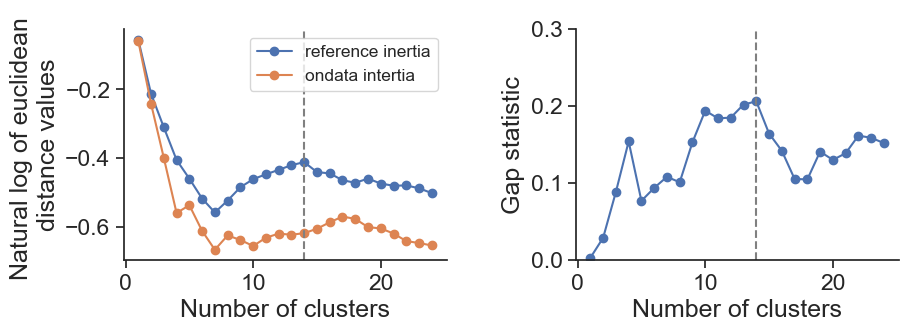

In [24]:
# plotting.plot_gap_statistic is not autoreloading
plotting.plot_gap_statistic(gap_dict, cre_lines=['all'], n_clusters_cre=n_clusters, 
                            tag='with_cre_shuffle', save_dir=save_dir, folder='selecting_k_clusters')

#### Eigen gap method

In [25]:
# this function will run eigengap if file does not exist
eigengap = processing.load_eigengap(glm_version, feature_matrix, cre_line='all', save_dir=clustering_results, k_max=25)

loading eigengap values scores from \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\clustering\eigengap_24_events_all_L2_optimize_by_session_kmax25_all.pkl
done


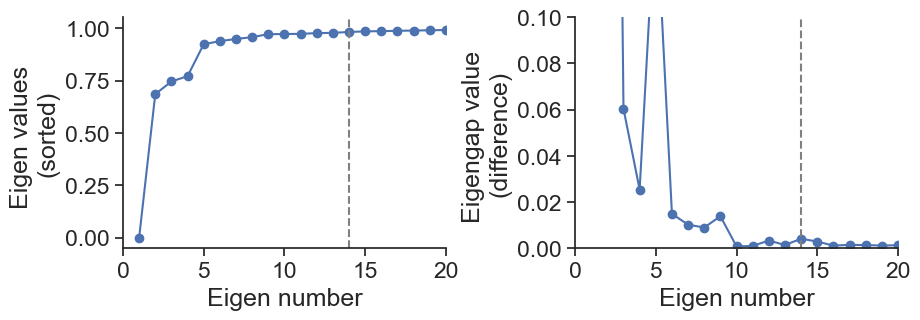

In [26]:
plotting.plot_eigengap_values(eigengap, cre_lines=['all'], n_clusters_cre={'all':n_clusters}, save_dir=save_dir, folder='selecting_k_clusters')

#### Silhouette Score method

In [27]:
n_clusters_range = np.arange(3, 25)
metric='euclidean'
n_boots=20

silhouette_filename= os.path.join(clustering_results, 'silhouette_score_{}_{}_clusters_metric_{}_nboots_{}.pkl'.format(n_clusters_range[0], n_clusters_range[-1], metric, n_boots))
if os.path.exists(silhouette_filename):
    with open(silhouette_filename, 'rb') as f:
        silhouette_scores, silhouette_std = pickle.load(f)

<AxesSubplot:xlabel='Number of clusters', ylabel='Silhouette score'>

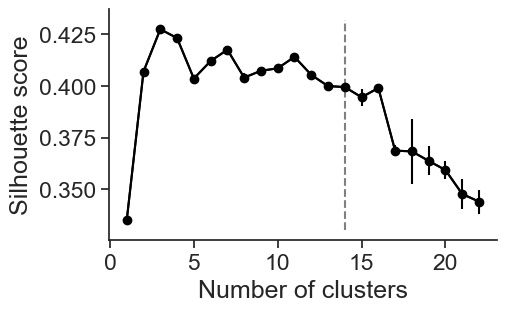

In [28]:
plotting.plot_silhouette_scores(silhouette_scores=silhouette_scores, silhouette_std=silhouette_std, metric=metric, 
                                n_clusters=n_clusters, save_dir=save_dir, folder='selecting_k_clusters')

### Clustering validation

#### Plot co-clustering matrix

In [29]:
# load co-clustering results
coclust_filename = os.path.join(clustering_results, 'coclustering_matrix_n_' + str(n_clusters) + '_clusters.h5')
coclustering_df = pd.read_hdf(coclust_filename, key='df')

In [30]:
coclustering_df.head()

cell_specimen_id  1086489847  1086489860  1086489891  1086489976  1086490002  \
cell_specimen_id                                                               
1086489847          1.006711    0.000000    1.006711    0.000000    0.000000   
1086489860          0.000000    1.006711    0.000000    0.000000    0.000000   
1086489891          1.006711    0.000000    1.006711    0.000000    0.000000   
1086489976          0.000000    0.000000    0.000000    1.006711    1.006711   
1086490002          0.000000    0.000000    0.000000    1.006711    1.006711   

cell_specimen_id  1086490039  1086490067  1086490073  1086490095  1086490100  \
cell_specimen_id                                                               
1086489847               0.0         0.0         0.0         0.0         0.0   
1086489860               0.0         0.0         0.0         0.0         0.0   
1086489891               0.0         0.0         0.0         0.0         0.0   
1086489976               0.0         0.0         0.0         0.0         0.0   
1086490002               0.0         0.0         0.0         0.0         0.0   

cell_specimen_id  ...  1120133177  1120133194  1120133281  1120133297  \
cell_specimen_id  ...                                                   
1086489847        ...         0.0         0.0    0.000000         0.0   
1086489860        ...         0.0         0.0    1.006711         0.0   
1086489891        ...         0.0         0.0    0.000000         0.0   
1086489976        ...         0.0         0.0    0.000000         0.0   
1086490002        ...         0.0         0.0    0.000000         0.0   

cell_specimen_id  1120133316  1120133342  1120133375  1120133471  1120133515  \
cell_specimen_id                                                               
1086489847               0.0         0.0    0.000000    0.000000         0.0   
1086489860               0.0         0.0    1.006711    0.000000         0.0   
1086489891               0.0         0.0    0.000000    0.000000         0.0   
1086489976               0.0         0.0    0.000000    1.006711         0.0   
1086490002               0.0         0.0    0.000000    1.006711         0.0   

cell_specimen_id  1120133649  
cell_specimen_id              
1086489847          0.000000  
1086489860          1.006711  
1086489891          0.000000  
1086489976          0.000000  
1086490002          0.000000  

[5 rows x 3921 columns]

<AxesSubplot:ylabel='cells'>

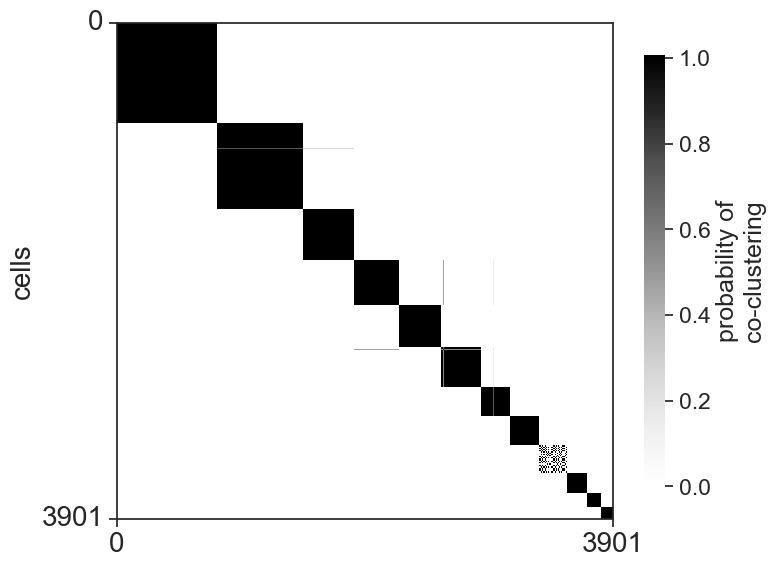

In [31]:
# plot coclustering matrix 
coclustering_dict = {}
coclustering_dict['all'] = coclustering_df
cluster_meta_tmp = cluster_meta.copy()
cluster_meta_tmp['cre_line'] = 'all'

plotting.plot_coclustering_matrix_sorted_by_cluster_size(coclustering_dict, cluster_meta_tmp, cre_line='all',
                                                                 suffix='_' + str(n_clusters) + '_clusters', 
                                                                 save_dir=save_dir, folder='clustering_results')

#### Within cluster correlation

adding within cluster correlation to cluster_meta


c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk_new\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk_new\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk_new\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk_new\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk_new\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk_new\lib\site-

<AxesSubplot:title={'center':'Within cluster correlation'}, xlabel='Cluster ID', ylabel='Spearman\ncorrelation'>

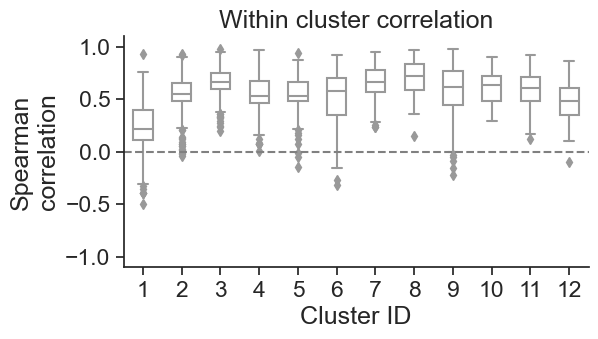

In [32]:
# plot within cluster correlations distribution
spearman = True
cluster_meta = processing.add_within_cluster_corr_to_cluster_meta(feature_matrix, cluster_meta, use_spearmanr=spearman)
plotting.plot_within_cluster_correlations(cluster_meta, sort_order=None, spearman=spearman, suffix='_'+str(n_clusters)+'_clusters',
                                                save_dir=save_dir, folder='clustering_results', ax=None)

In [33]:
# # plot within cluster correlations distribution
# spearman = False
# cluster_meta = processing.add_within_cluster_corr_to_cluster_meta(feature_matrix, cluster_meta, use_spearmanr=spearman)
# plotting.plot_within_cluster_correlations(cluster_meta, sort_order=None, spearman=spearman, suffix='_'+str(n_clusters)+'_clusters',
#                                                 save_dir=save_dir, folder='clustering_results', ax=None)

#### UMAP

In [34]:
# get saved umap results
umap_df = processing.get_umap_results(feature_matrix, cluster_meta, save_dir=clustering_results, suffix='')

loading umap results from \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\clustering\umap_results_df.h5


using provided umap_df


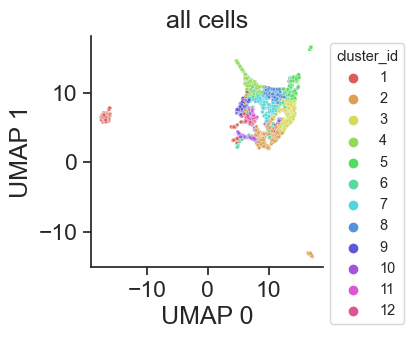

In [35]:
# show all clusters in same plot
plotting.plot_umap_for_clusters(cluster_meta, feature_matrix, umap_df, label_col='cluster_id', cre_lines = ['all'],
                                save_dir=save_dir, folder='cluster_results')

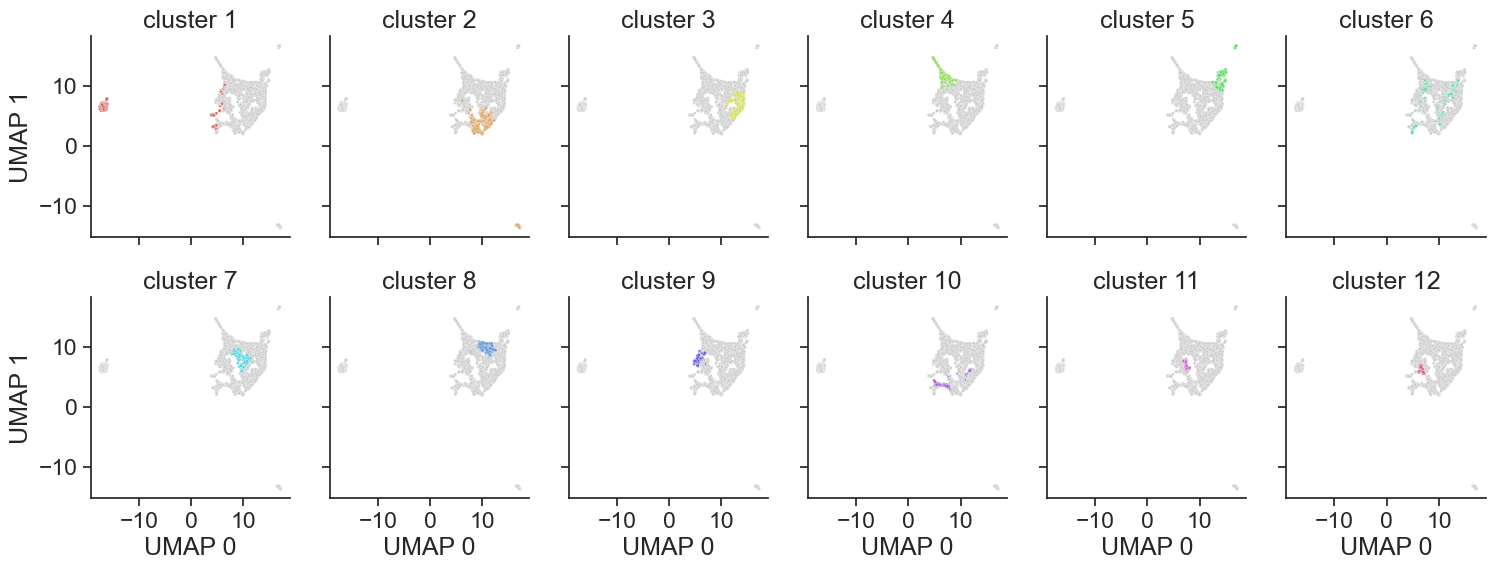

In [36]:
# plot clusters in separate axes
plotting.plot_umap_for_clusters_separately(cluster_meta, feature_matrix, umap_df, label_col='cluster_id', save_dir=save_dir, folder='clustering_results')

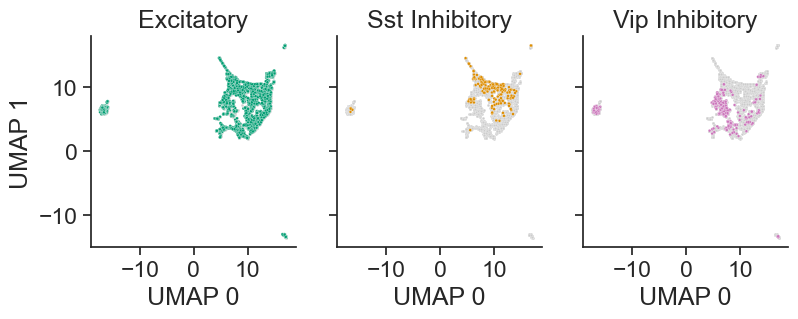

In [37]:
# plot cell type distribution 
cmap = utils.get_cell_type_colors()
plotting.plot_umap_for_features_separately(cluster_meta, feature_matrix, umap_df, label_col='cell_type', cmap=cmap, save_dir=save_dir, folder='clustering_results')

#### Distribution of animals and rigs across clusters

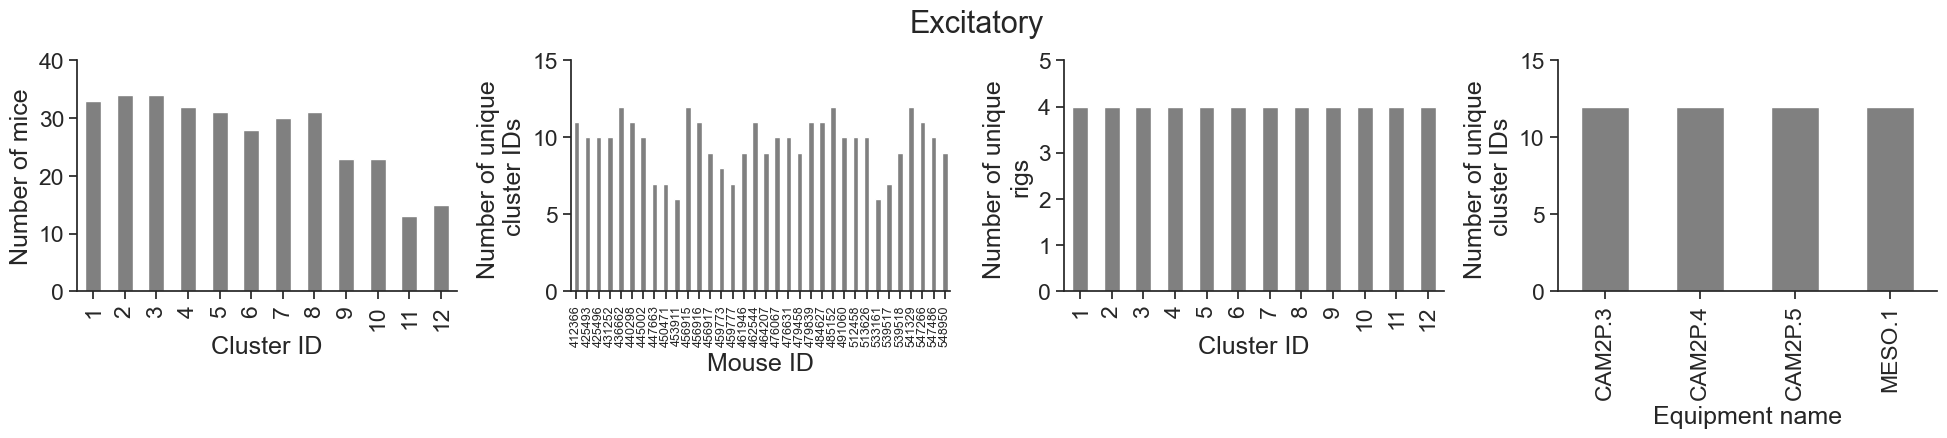

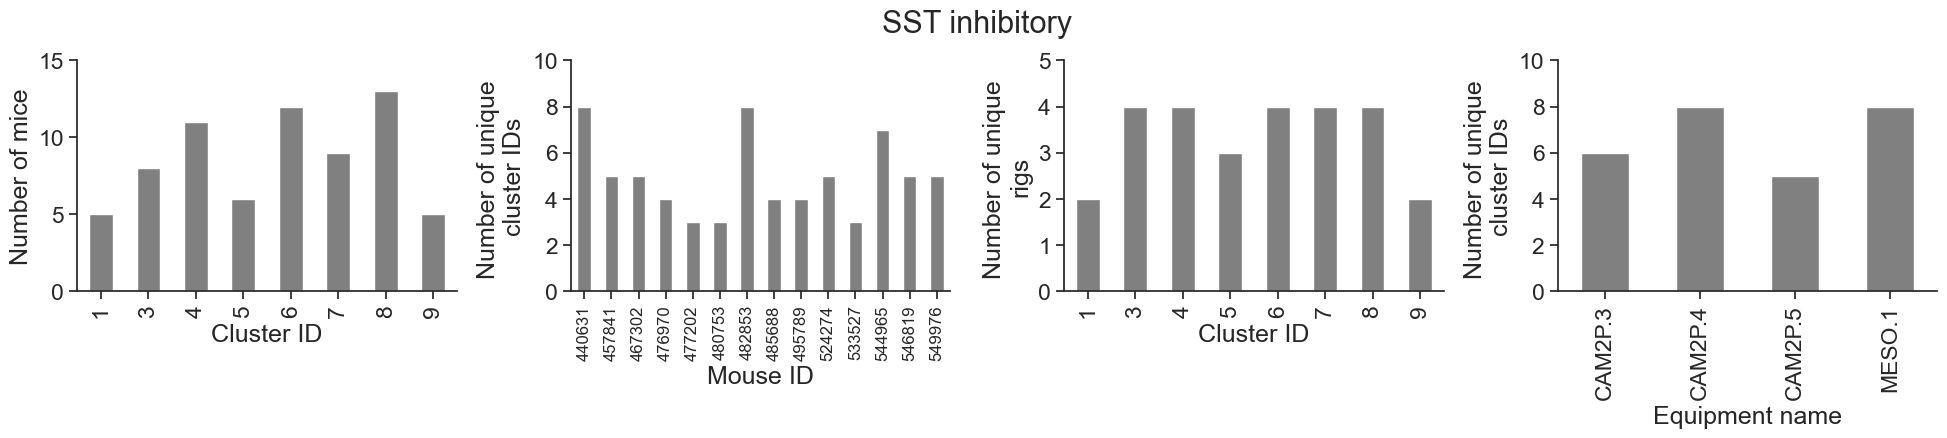

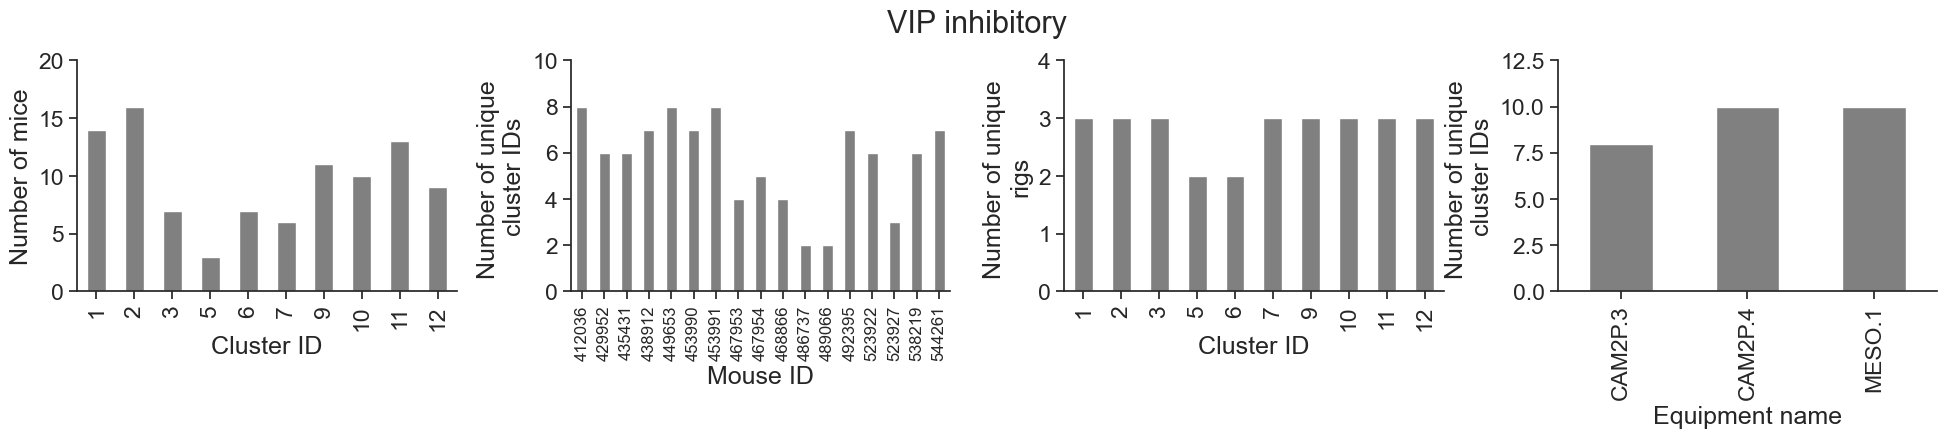

In [38]:
plotting.plot_cluster_info(cre_lines, cluster_meta, save_dir=save_dir, folder='clustering_controls')

## Clustering results

### Coding scores for clusters

#### Coding score heatmaps

C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:560: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cre_line is 'all':


<AxesSubplot:xlabel='cells'>

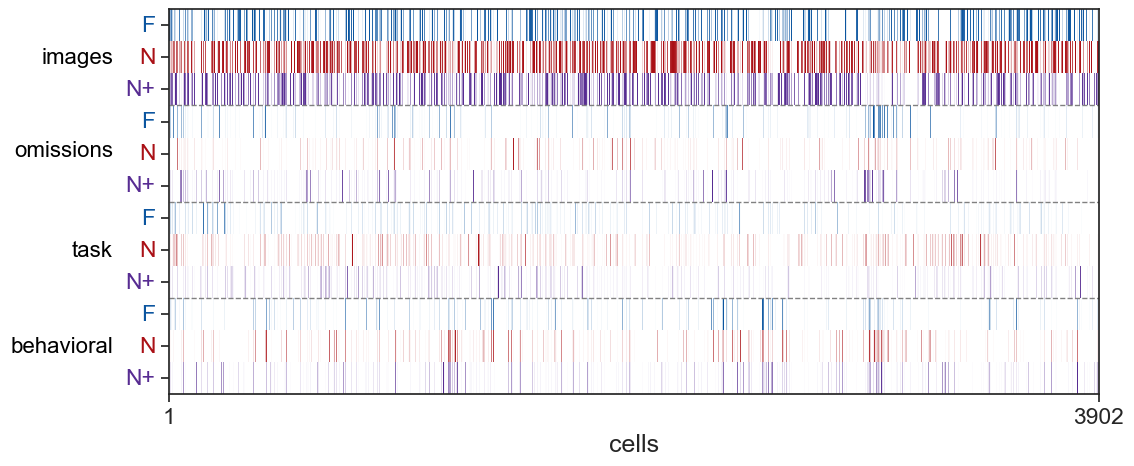

In [44]:
# plot unsorted coding scores for matched cells
cluster_meta_tmp = cluster_meta.copy()
cluster_meta_tmp['cell_index'] = cluster_meta_tmp.index.values
plotting.plot_coding_score_heatmap_remapped(cluster_meta_tmp, feature_matrix, sort_by=None, session_colors=True,
                                    save_dir=save_dir, folder='clustering_results')

<AxesSubplot:xlabel='Cluster ID'>

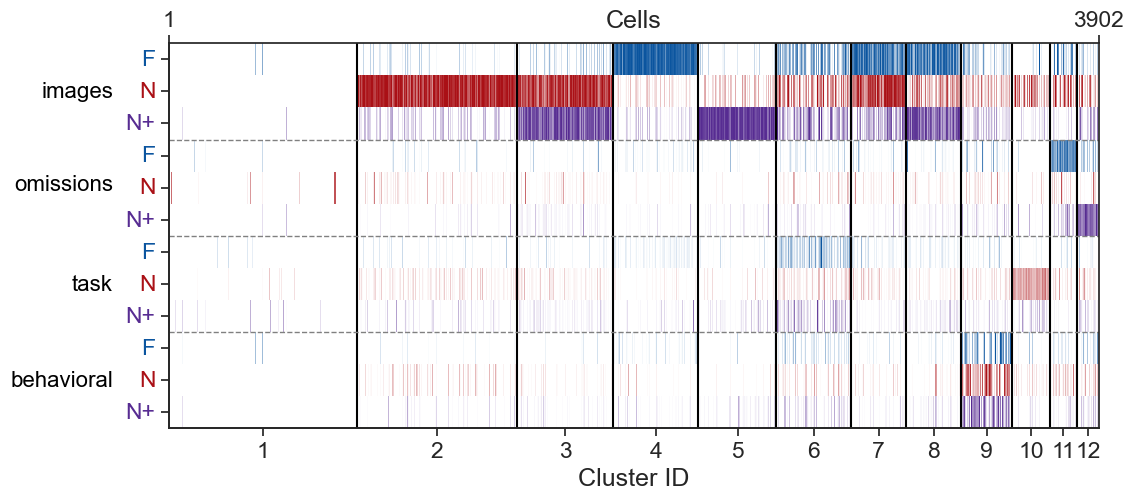

In [45]:
# plot coding scores for matched cells sorted by clusters
cluster_meta_tmp = cluster_meta.copy()
cluster_meta_tmp['cell_index'] = cluster_meta_tmp.index.values
plotting.plot_coding_score_heatmap_remapped(cluster_meta_tmp, feature_matrix, session_colors=True,
                                    save_dir=save_dir, folder='clustering_results')

C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:1509: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  cluster_means = feature_matrix.merge(cluster_meta[['cluster_id']], on='cell_specimen_id').groupby('cluster_id').mean()


<Axes: title={'center': 'Cluster averages'}, xlabel='Cluster ID'>

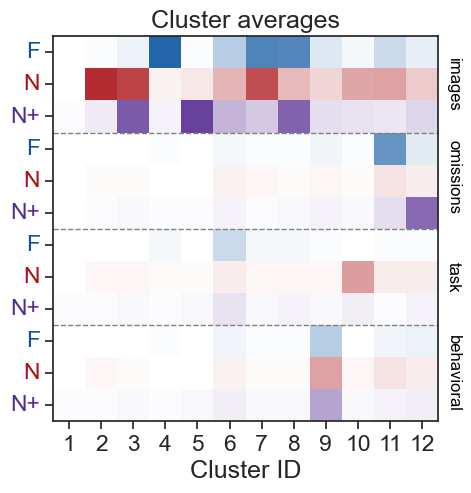

In [45]:
# plot average of each cluster
plotting.plot_cluster_means_remapped(feature_matrix, cluster_meta, save_dir=save_dir, folder='clustering_results')

C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:1520: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  cre_line_means = feature_matrix.merge(cluster_meta[['cre_line']], on='cell_specimen_id').groupby('cre_line').mean()


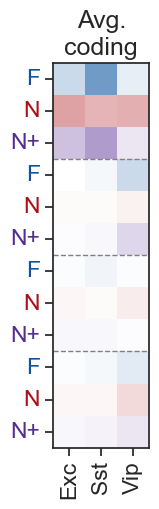

In [46]:
# plot average coding scores for each cre line (average of matched cells only)
plotting.plot_cre_line_means_remapped(feature_matrix, cluster_meta, save_dir=save_dir, folder='clustering_results')

C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:1785: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


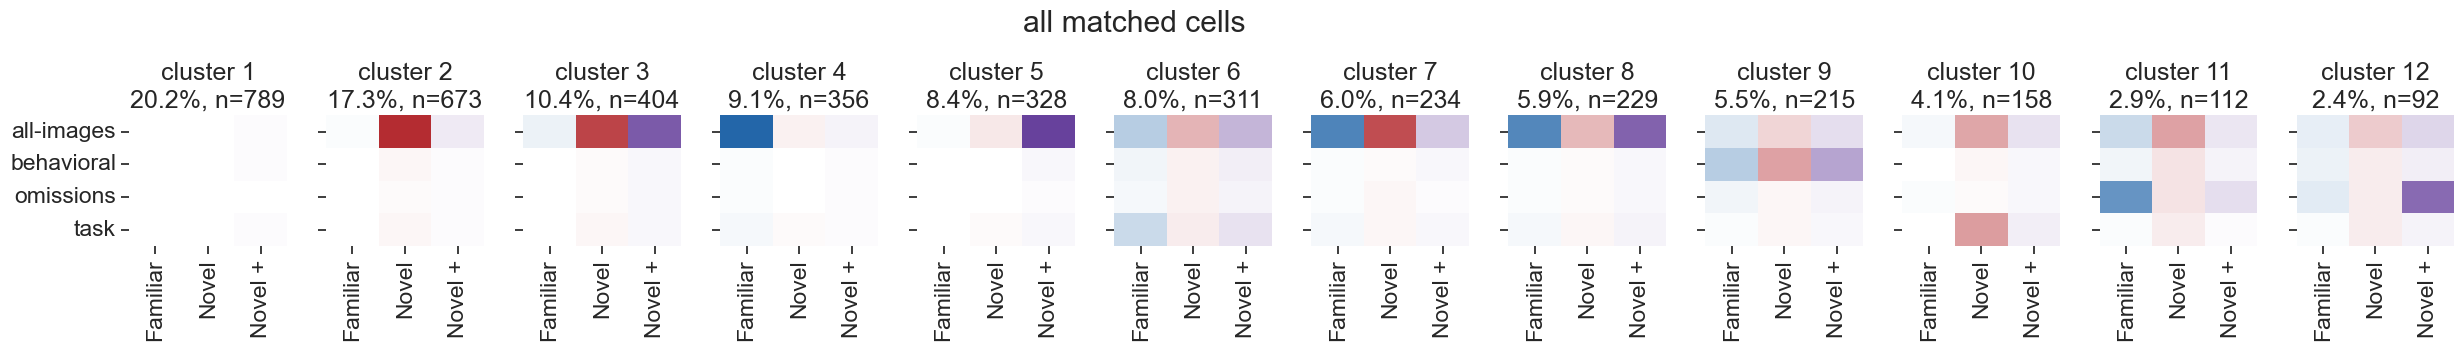

In [47]:
# plot average of each cluster as separate heatmaps
clusters = cluster_meta.value_counts('cluster_id').index.values
plotting.plot_mean_cluster_heatmaps_remapped(feature_matrix, cluster_meta, save_dir=save_dir, folder='clustering_results')

### Population averages for clusters 

#### Image change and repeated image responses

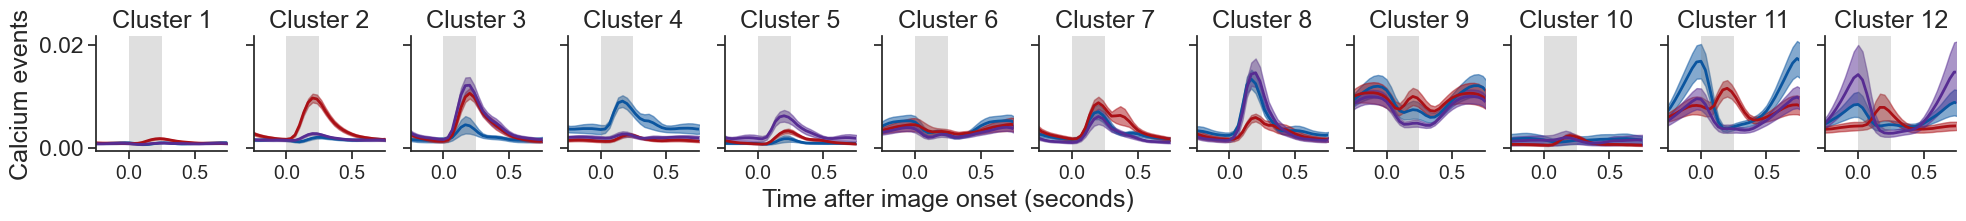

In [114]:
# average repeated image response across all cells in each cluster
tmp = image_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]

xlim_seconds = [-0.25, 0.75]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

plotting.plot_population_averages_for_clusters(tmp, 'images', axes_column, hue_column, 
                                            xlim_seconds=xlim_seconds, interval_sec=0.5, 
                                            sharey=True, sharex=True, 
                                            ylabel='Calcium events', xlabel='Time after image onset (seconds)', suptitle=None,
                                            save_dir=save_dir, folder='population_averages', suffix='_images', ax=None);

In [118]:
# # average change response across all cells in each cluster
# # scaled so the xaxis is a bit wider than just for images alone
# tmp = change_mdf.copy()
# tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]


# xlim_seconds = [-0.9, 0.75]
# timestamps = tmp.trace_timestamps.values[0]

# axes_column = 'cluster_id'
# hue_column = 'experience_level'

# suffix = '_changes'

# plotting.plot_population_averages_for_clusters(tmp, 'changes', axes_column, hue_column, 
#                                             xlim_seconds=xlim_seconds, interval_sec=0.5, 
#                                             sharey=True, sharex=True, scale_x=True,
#                                             ylabel='Calcium events', xlabel='Time relative to change (seconds)', suptitle=None,
#                                             save_dir=save_dir, folder='population_averages', suffix=suffix, ax=None);

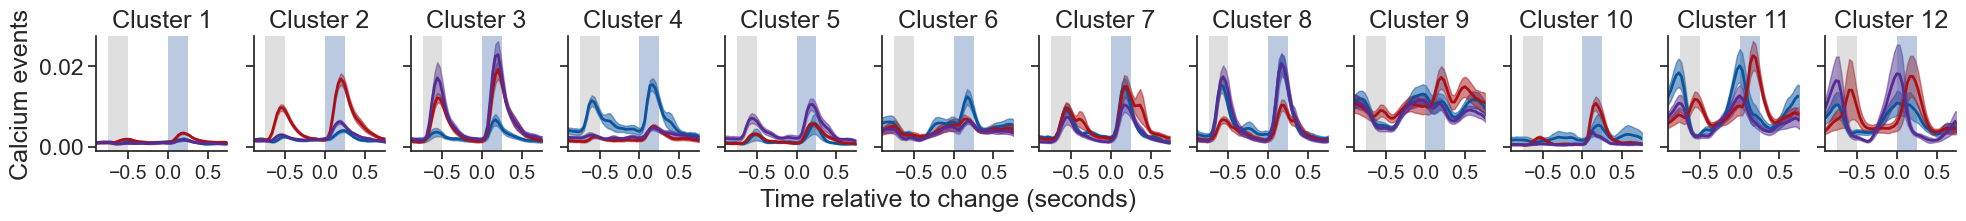

In [123]:
# without scaling - will be same size as image response plots
tmp = change_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]


xlim_seconds = [-0.9, 0.75]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

suffix = '_changes_unscaled'

plotting.plot_population_averages_for_clusters(tmp, 'changes', axes_column, hue_column, 
                                            xlim_seconds=xlim_seconds, interval_sec=0.5, 
                                            sharey=True, sharex=True, scale_x=False,
                                            ylabel='Calcium events', xlabel='Time relative to change (seconds)', suptitle=None,
                                            save_dir=save_dir, folder='population_averages', suffix=suffix, ax=None);

#### Omission responses

In [120]:
# # average omission response across all cells in each cluster
# # scaled so the xaxis is a bit wider than just for images alone
# tmp = omission_mdf.copy()
# tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]

# xlim_seconds = [-1, 1.5]
# timestamps = tmp.trace_timestamps.values[0]

# axes_column = 'cluster_id'
# hue_column = 'experience_level'

# suffix = '_omissions'

# plotting.plot_population_averages_for_clusters(tmp, 'omissions', axes_column, hue_column, 
#                                             xlim_seconds=xlim_seconds, interval_sec=1, 
#                                             sharey=True, sharex=True, scale_x=True, 
#                                             ylabel='Calcium events', xlabel='Time relative to omission (seconds)', suptitle=None,
#                                             save_dir=save_dir, folder='population_averages', suffix=suffix, ax=None);

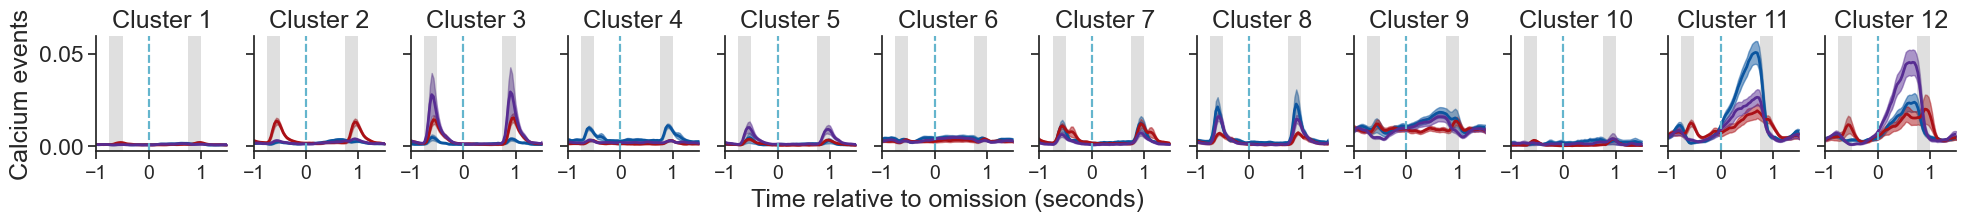

In [122]:
# scaled to match the width of images only plots
tmp = omission_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]

xlim_seconds = [-1, 1.5]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

suffix = '_omissions_unscaled'

plotting.plot_population_averages_for_clusters(tmp, 'omissions', axes_column, hue_column, 
                                            xlim_seconds=xlim_seconds, interval_sec=1, 
                                            sharey=True, sharex=True, scale_x=False, 
                                            ylabel='Calcium events', xlabel='Time relative to omission (seconds)', suptitle=None,
                                            save_dir=save_dir, folder='population_averages', suffix=suffix, ax=None);

### Fraction cells per cre line per cluster

12 12
8 12
10 12


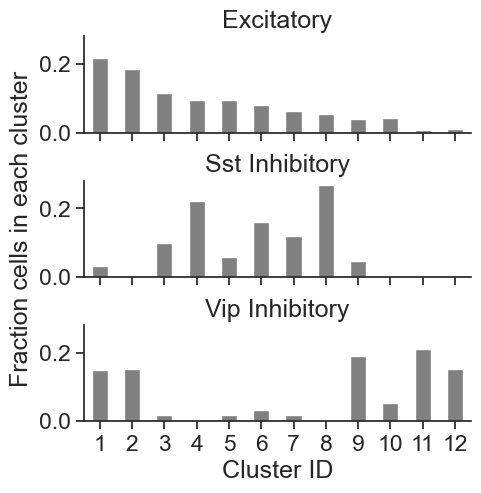

In [53]:
plotting.plot_fraction_cells_per_cluster_per_cre(cluster_meta, col_to_group='cre_line', 
                                                    save_dir=save_dir, folder='clustering_results')

In [54]:
cell_counts = cluster_meta.groupby(['cell_type']).count().rename(columns={'cre_line':'n_cells'})[['n_cells']]
cell_counts.head()

n_cells
cell_type              
Excitatory         3298
Sst Inhibitory      194
Vip Inhibitory      409

In [55]:
cell_counts = cluster_meta.reset_index().drop_duplicates(subset='cell_specimen_id').copy()
cell_counts = cell_counts.groupby(['cell_type']).count()
cell_counts.head()

cell_specimen_id  cluster_id  labels  ophys_experiment_id  \
cell_type                                                                   
Excitatory                  3298        3298    3298                 3298   
Sst Inhibitory               194         194     194                  194   
Vip Inhibitory               409         409     409                  409   

                behavior_session_id  ophys_session_id  ophys_container_id  \
cell_type                                                                   
Excitatory                     3298              3298                3298   
Sst Inhibitory                  194               194                 194   
Vip Inhibitory                  409               409                 409   

                mouse_id  indicator  full_genotype  ...  area_layer  date  \
cell_type                                           ...                     
Excitatory          3298       3298           3298  ...        3298  3298   
Sst Inhibitory       194        194            194  ...         194   194   
Vip Inhibitory       409        409            409  ...         409   409   

                first_novel  n_relative_to_first_novel  last_familiar  \
cell_type                                                               
Excitatory             3298                       3298           3298   
Sst Inhibitory          194                        194            194   
Vip Inhibitory          409                        409            409   

                last_familiar_active  second_novel  second_novel_active  \
cell_type                                                                 
Excitatory                      3298          3298                 3298   
Sst Inhibitory                   194           194                  194   
Vip Inhibitory                   409           409                  409   

                experience_exposure  within_cluster_correlation  
cell_type                                                        
Excitatory                     3298                        2673  
Sst Inhibitory                  194                         190  
Vip Inhibitory                  409                         364  

[3 rows x 49 columns]

#### Distribution of clusters by depth

array([<Axes: title={'center': 'Excitatory'}>,
       <Axes: title={'center': 'Sst Inhibitory'}, ylabel='Fraction cells in each depth'>,
       <Axes: title={'center': 'Vip Inhibitory'}, xlabel='Cluster ID'>],
      dtype=object)

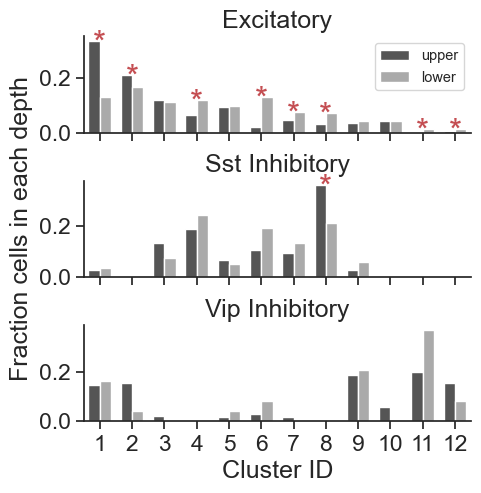

In [271]:
location = 'layer'
metric = 'fraction_cells_location'
ylabel = 'Fraction cells in each depth'

plotting.plot_cluster_depth_distribution_by_cre_lines(cluster_meta, location, metric, ylabel=ylabel, save_dir=save_dir, folder='area_depth')

array([<Axes: title={'center': 'Excitatory'}>,
       <Axes: title={'center': 'Sst Inhibitory'}, ylabel='Fraction cells in each depth'>,
       <Axes: title={'center': 'Vip Inhibitory'}, xlabel='Cluster ID'>],
      dtype=object)

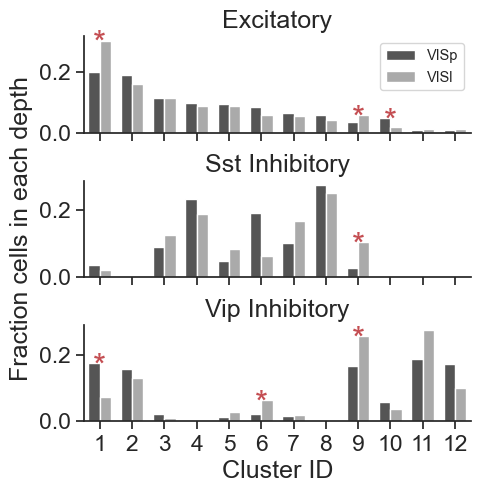

In [272]:
location = 'targeted_structure'
metric = 'fraction_cells_location'
ylabel = 'Fraction cells in each depth'

plotting.plot_cluster_depth_distribution_by_cre_lines(cluster_meta, location, metric, ylabel=ylabel, save_dir=save_dir, folder='area_depth')

C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:3729: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  hue=hue, hue_order=hue_order, palette=palette, width=0.7, ax=ax[i])
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:3729: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  hue=hue, hue_order=hue_order, palette=palette, width=0.7, ax=ax[i])
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:3729: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  hue=hue, hue_order=hue_order, palette=palette, width=0.7, ax=ax[i])


array([<Axes: title={'center': 'Excitatory'}>,
       <Axes: title={'center': 'Sst Inhibitory'}, ylabel='Fraction cells in each depth'>,
       <Axes: title={'center': 'Vip Inhibitory'}, xlabel='Cluster ID'>],
      dtype=object)

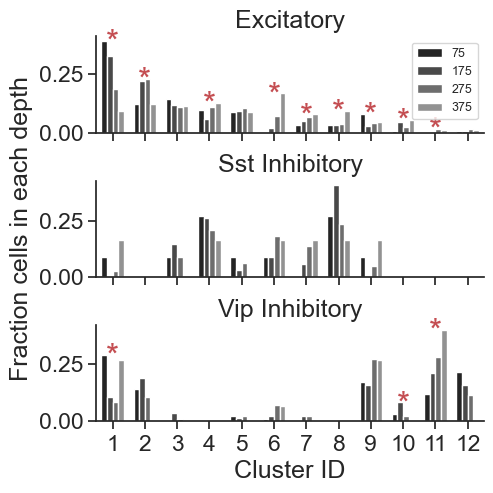

In [273]:
location = 'binned_depth'
metric = 'fraction_cells_location'
ylabel = 'Fraction cells in each depth'

plotting.plot_cluster_depth_distribution_by_cre_lines(cluster_meta, location, metric, ylabel=ylabel, save_dir=save_dir, folder='area_depth')

### Clustering results for each cell type

#### Coding scores per cell type per cluster

In [56]:
# # plot feature matrix for each cre line, sorted by cluster size
# feature_matrix_remapped, remapped_cmap, vmax = plotting.remap_coding_scores_to_session_colors(feature_matrix)

# plotting.plot_feature_matrix_sorted(feature_matrix_remapped, cluster_meta, sort_col='cluster_id', resort_by_size=True,
#                                     cmap=remapped_cmap, vmax=vmax, save_dir=save_dir, folder='clustering_results')

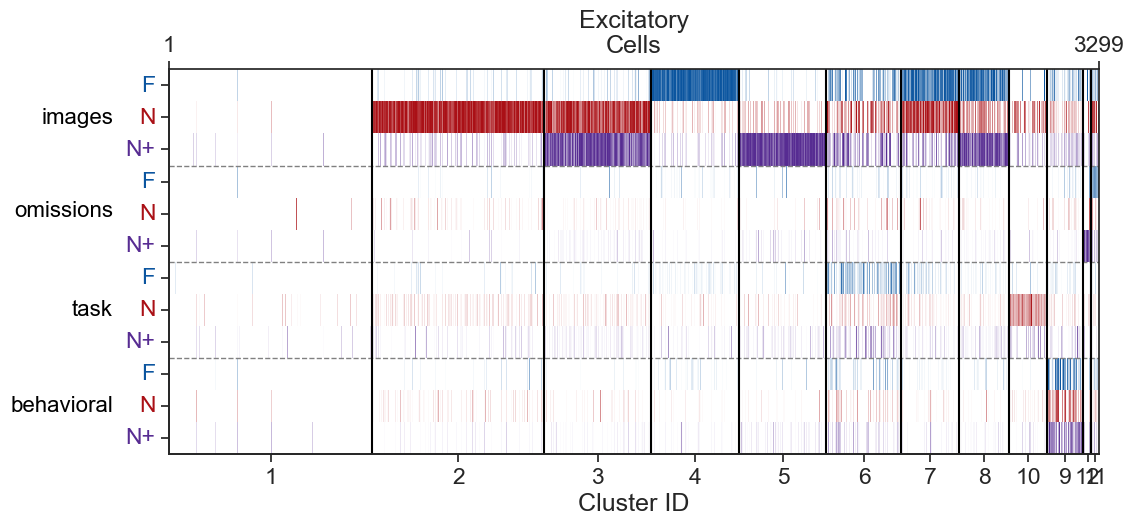

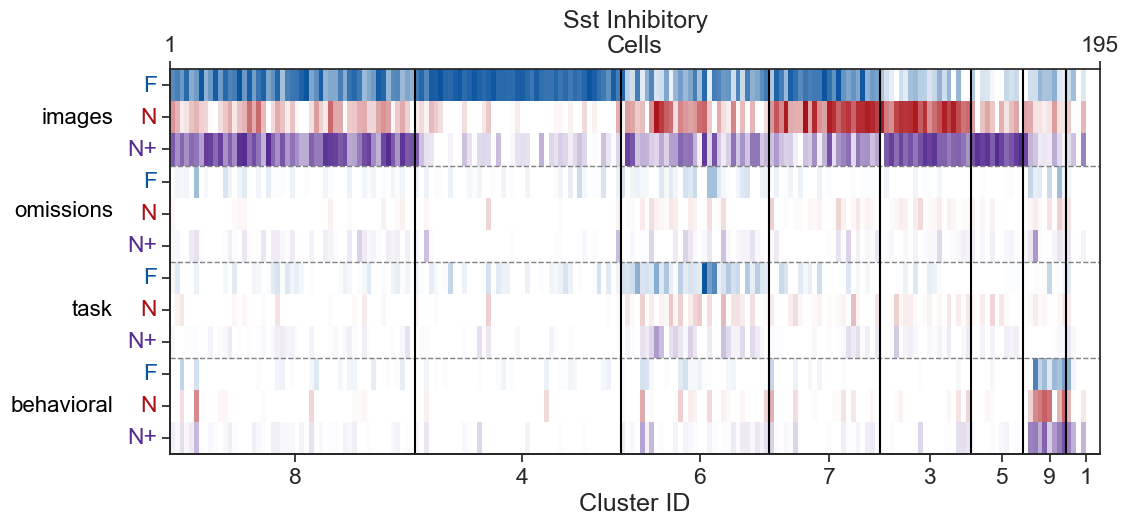

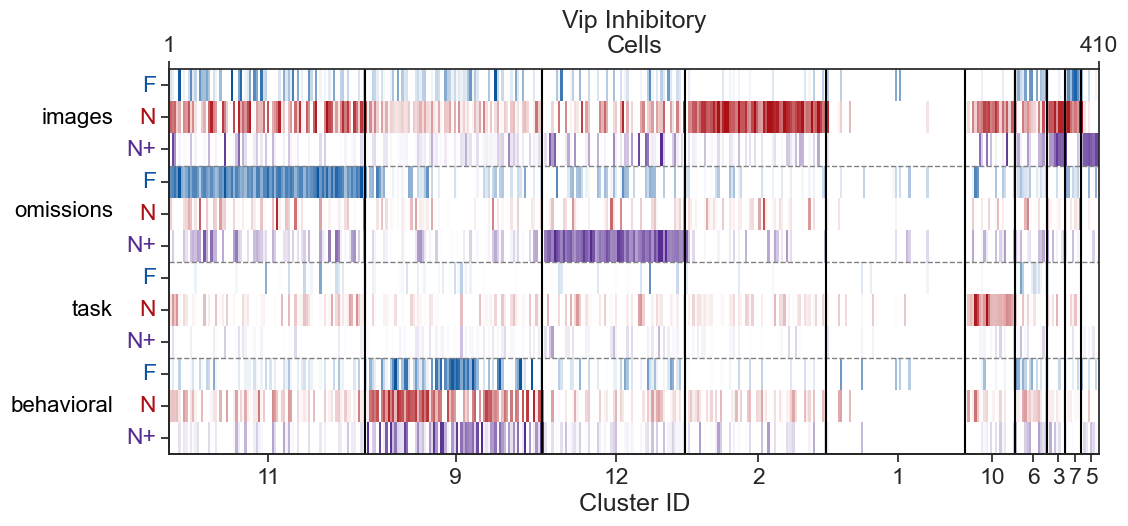

In [57]:
# plot coding scores for matched cells sorted by clusters
for cre_line in cre_lines:
    cluster_meta_cre = cluster_meta[cluster_meta.cre_line==cre_line].copy()
    cluster_meta_cre['cell_index'] = cluster_meta_cre.index.values
    plotting.plot_coding_score_heatmap_remapped(cluster_meta_cre, feature_matrix, session_colors=True, sort_by='cluster_size',
                                        save_dir=None, folder='clustering_results', suffix='_'+cre_line.split('-')[0], title=utils.convert_cre_line_to_cell_type(cre_line))

C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:560: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cre_line is 'all':
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:1791: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  def plot_coding_score_heatmap_remapped(cluster_meta, feature_matrix, sort_by='cluster_id',
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:1791: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  def plot_coding_score_heatmap_remapped(cluster_meta, feature_matrix, sort_by='cluster_id',
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduc

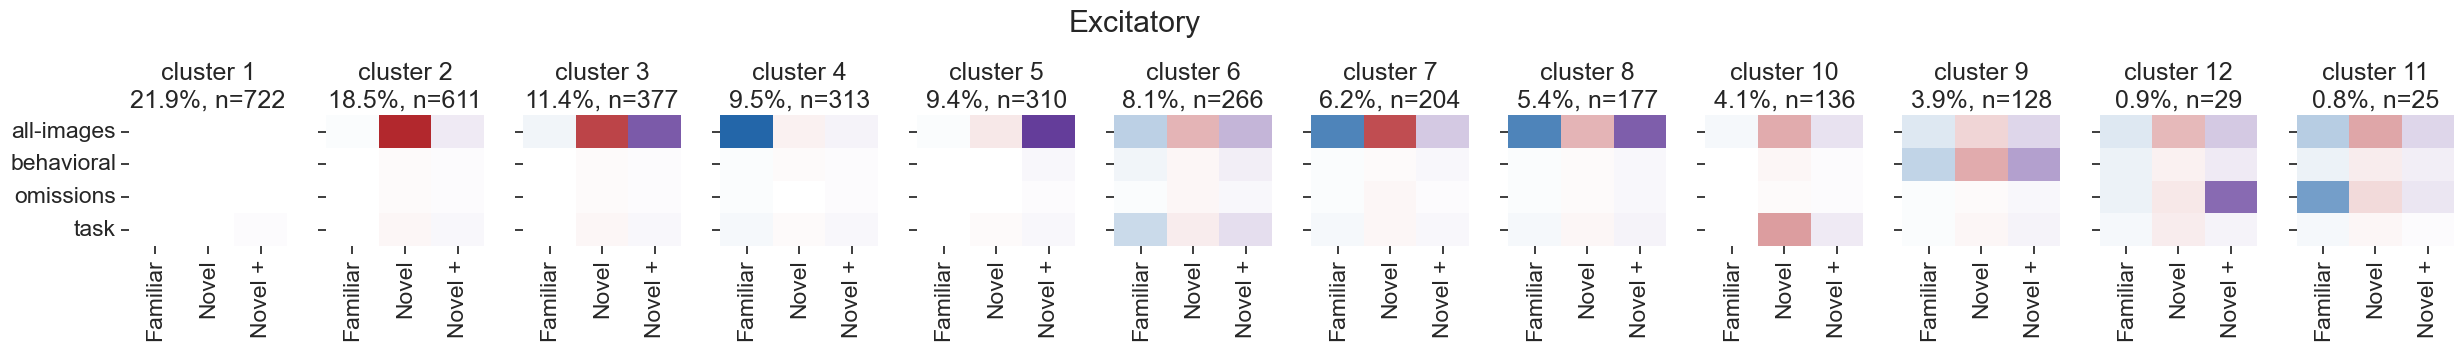

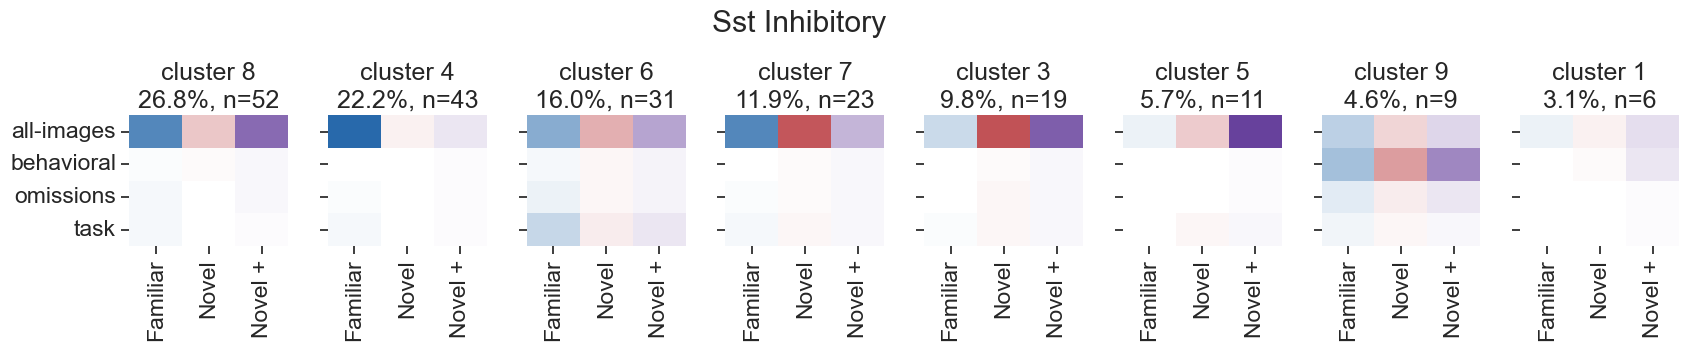

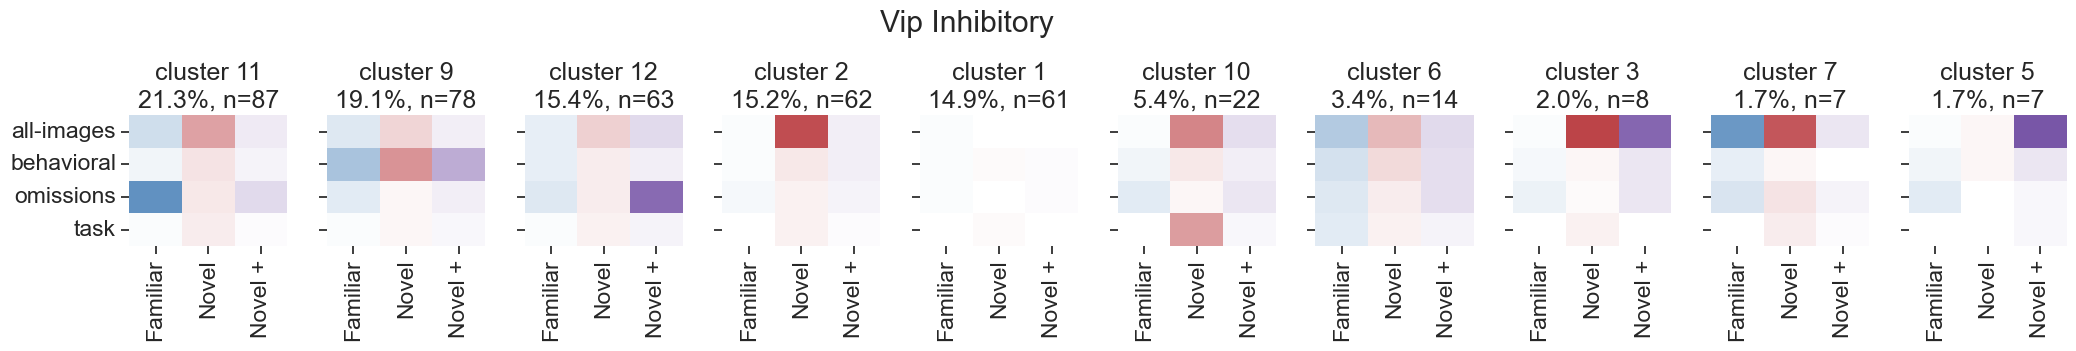

In [207]:
# cluster averages sorted by size within each cre line
for cre_line in cre_lines:
    plotting.plot_mean_cluster_heatmaps_remapped(feature_matrix, cluster_meta, cre_line, 
                                                sort_by='cluster_size', save_dir=save_dir, folder='clustering_results')

#### Population averages per cell type per cluster

C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:560: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cre_line is 'all':


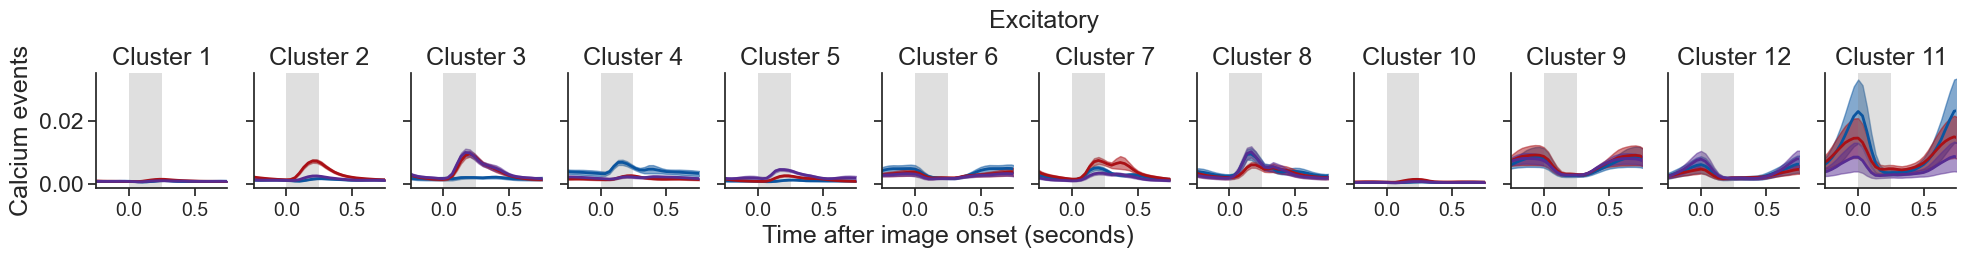

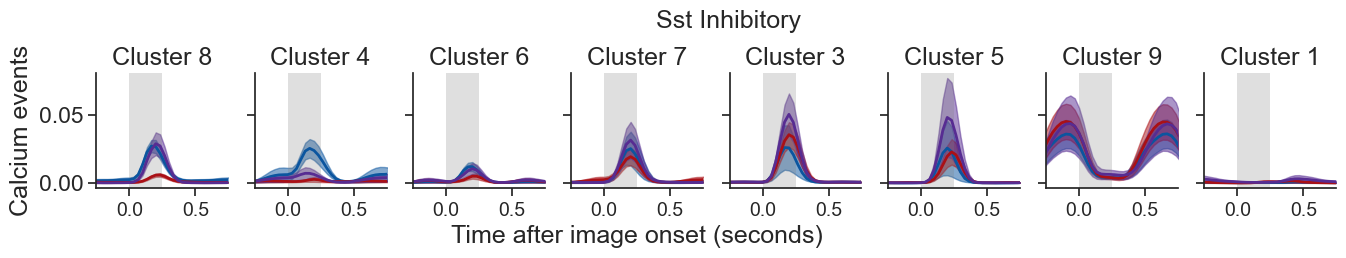

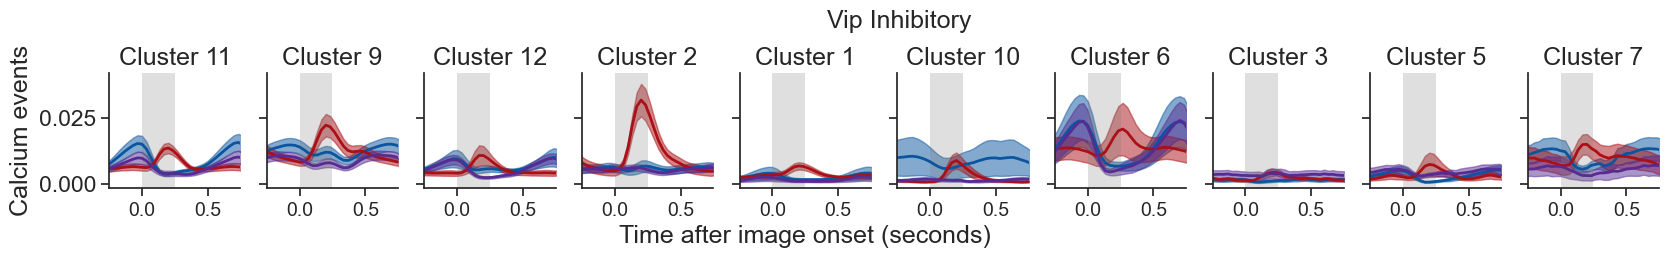

In [209]:
# average repeated image response across all cells in each cluster
tmp = image_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.7))]

xlim_seconds = [-0.25, 0.75]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

for cre_line in cre_lines: 

    suffix = '_images_'+cre_line.split('-')[0]

    plotting.plot_population_averages_for_clusters(tmp[tmp.cre_line==cre_line], 'images', axes_column, hue_column, 
                                                    xlim_seconds=xlim_seconds, interval_sec=0.5, 
                                                    sharey=True, sharex=True, suptitle=utils.convert_cre_line_to_cell_type(cre_line),
                                                    ylabel='Calcium events', xlabel='Time after image onset (seconds)', scale_x=False,
                                                    save_dir=save_dir, folder='population_averages', suffix=suffix, ax=None);

C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:560: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cre_line is 'all':


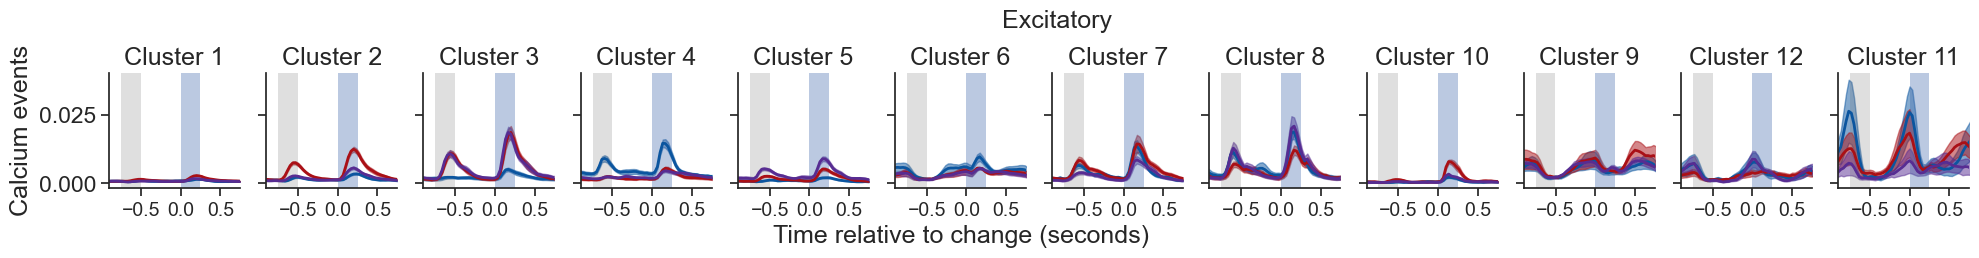

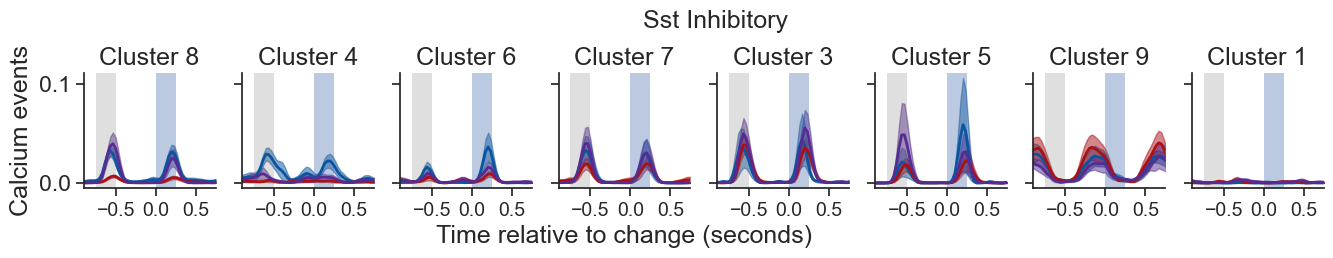

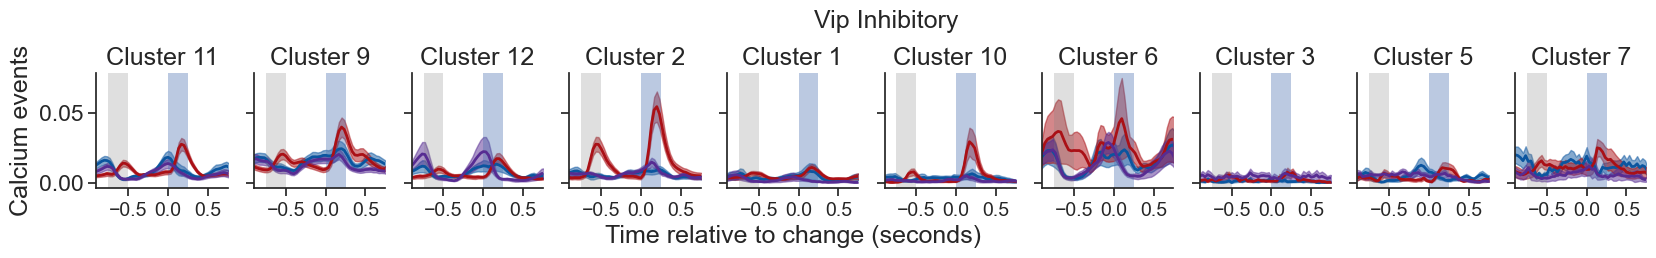

In [211]:
# average change response across all cells in each cluster
# scaled so the xaxis is a bit wider than just for images alone
tmp = change_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.7))]


xlim_seconds = [-0.9, 0.75]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

for cre_line in cre_lines: 

    suffix = '_changes_'+cre_line.split('-')[0]

    plotting.plot_population_averages_for_clusters(tmp[tmp.cre_line==cre_line], 'changes', axes_column, hue_column, 
                                                    xlim_seconds=xlim_seconds, interval_sec=0.5, 
                                                    sharey=True, sharex=True, suptitle=utils.convert_cre_line_to_cell_type(cre_line),
                                                    ylabel='Calcium events', xlabel='Time relative to change (seconds)', scale_x=False,
                                                    save_dir=save_dir, folder='population_averages', suffix=suffix, ax=None);

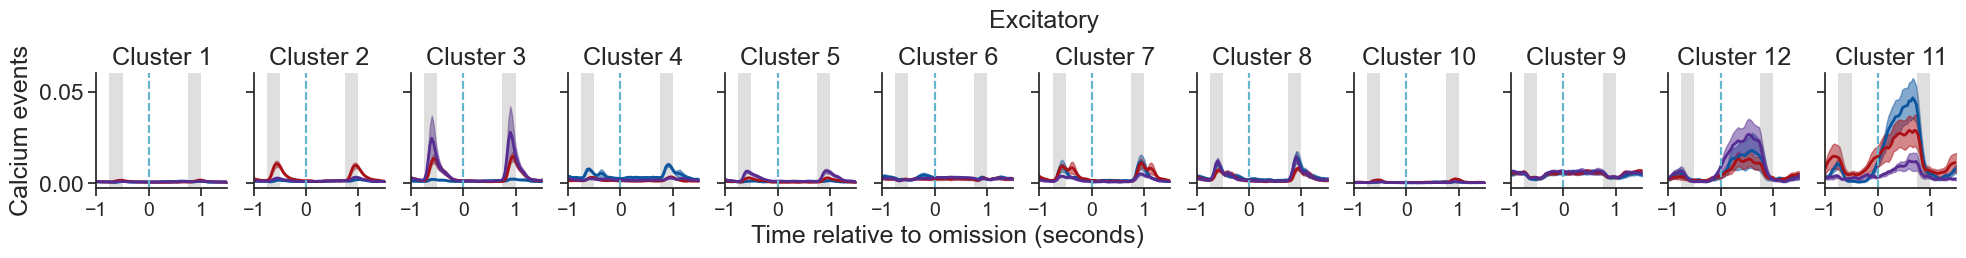

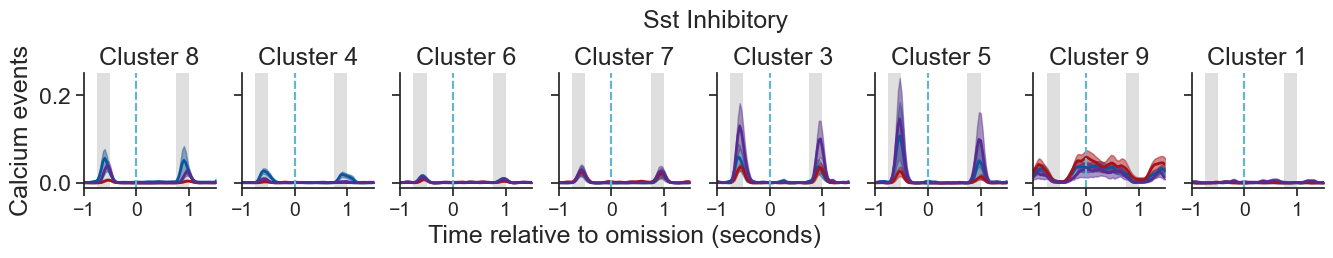

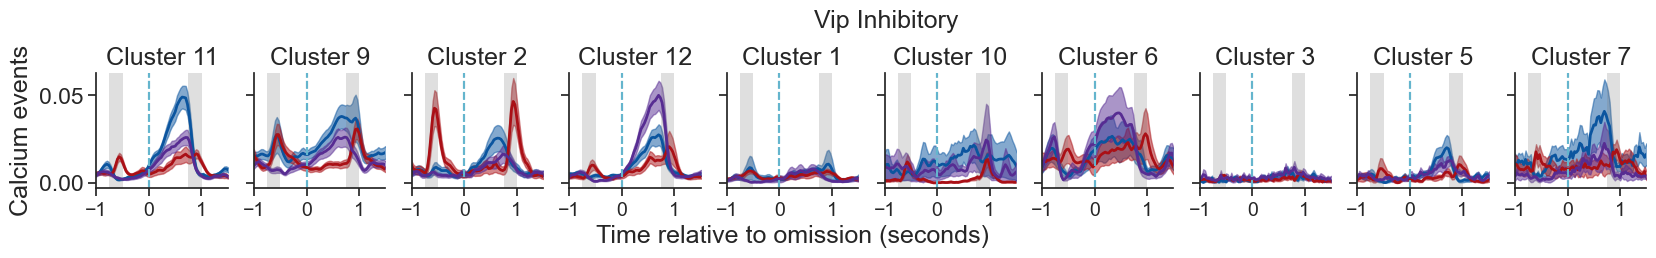

In [212]:
# average omission response across all cells in each cluster
# scaled so the xaxis is a bit wider than just for images alone
tmp = omission_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.7))]

xlim_seconds = [-1, 1.5]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

for cre_line in cre_lines: 

    suffix = '_omissions_'+cre_line.split('-')[0]

    plotting.plot_population_averages_for_clusters(tmp[tmp.cre_line==cre_line], 'omissions', axes_column, hue_column, 
                                                    xlim_seconds=xlim_seconds, interval_sec=1, 
                                                    sharey=True, sharex=True, suptitle=utils.convert_cre_line_to_cell_type(cre_line),
                                                    ylabel='Calcium events', xlabel='Time relative to omission (seconds)', scale_x=False,
                                                    save_dir=save_dir, folder='population_averages', suffix=suffix, ax=None);

#### Cluster sizes

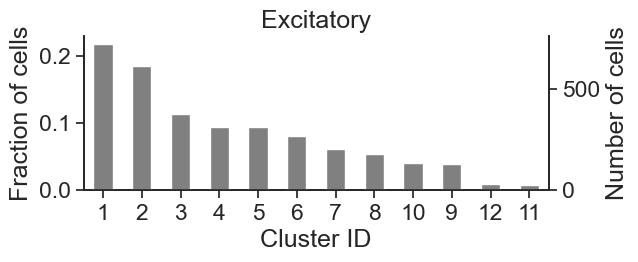

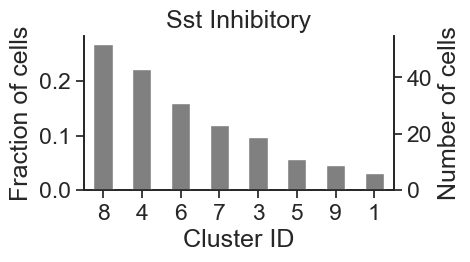

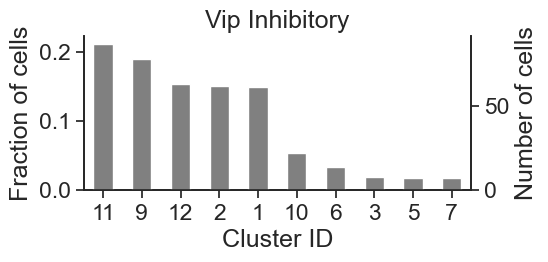

In [206]:
plotting.plot_fraction_and_number_cells_per_cluster_per_cre(cluster_meta, save_dir=save_dir, folder='area_depth')

#### Area depth distributions per cre line

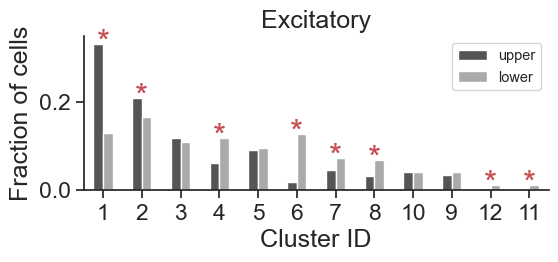

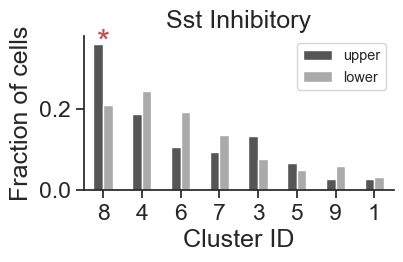

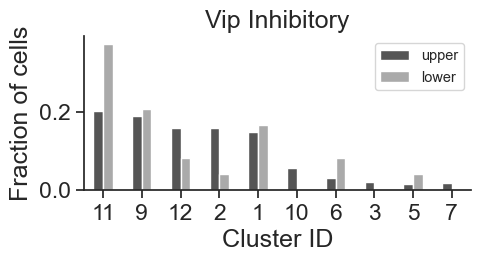

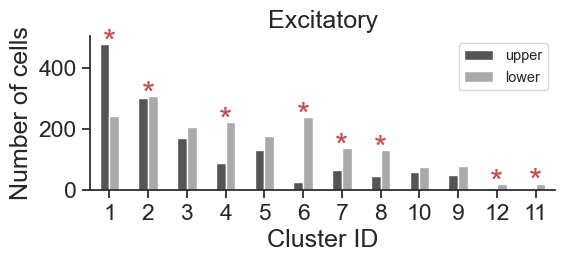

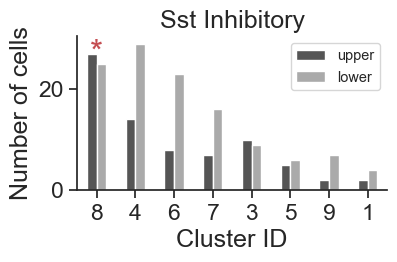

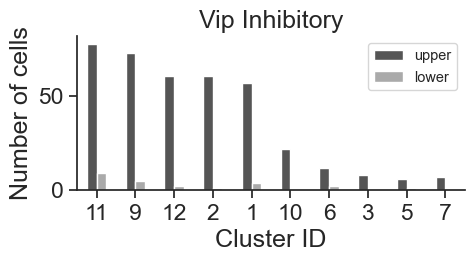

In [274]:
location = 'layer'

metric = 'fraction_cells_location'
ylabel = 'Fraction of cells'
plotting.plot_cluster_depth_distribution_by_cre_line_separately(cluster_meta, location, metric, ylabel, save_dir=save_dir, folder='area_depth')


metric = 'n_cells_location'
ylabel = 'Number of cells'
plotting.plot_cluster_depth_distribution_by_cre_line_separately(cluster_meta, location, metric, ylabel, save_dir=save_dir, folder='area_depth')

C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:3800: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  figsize = (6, 4)
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:3800: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  figsize = (6, 4)
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:3800: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  figsize = (6, 4)
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:3800: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  figsize = (6, 4)
C:\Users\marinag\Documents\Code\visual_b

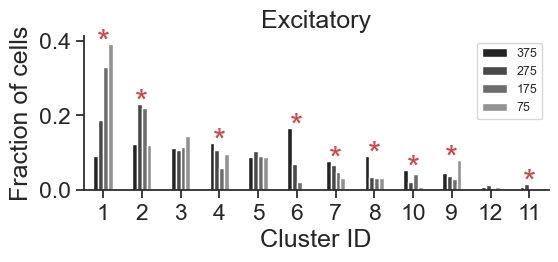

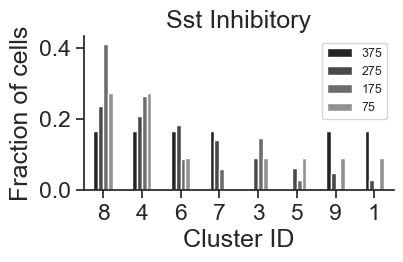

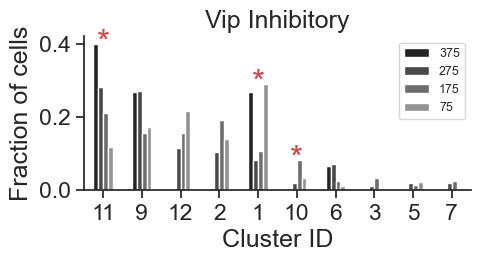

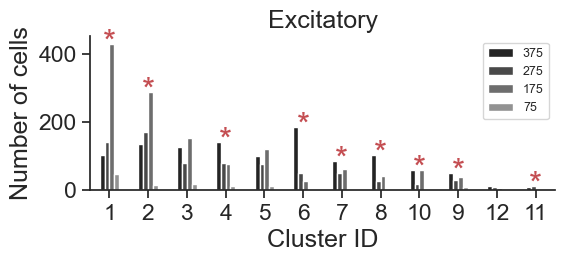

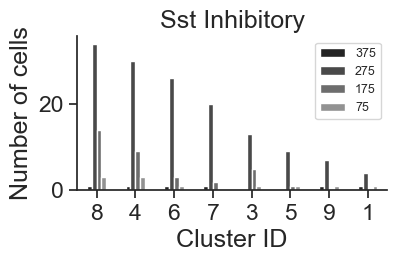

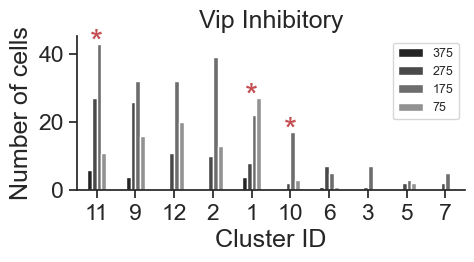

In [275]:
location = 'binned_depth'

metric = 'fraction_cells_location'
ylabel = 'Fraction of cells'
plotting.plot_cluster_depth_distribution_by_cre_line_separately(cluster_meta, location, metric, ylabel, save_dir=save_dir, folder='area_depth')


metric = 'n_cells_location'
ylabel = 'Number of cells'
plotting.plot_cluster_depth_distribution_by_cre_line_separately(cluster_meta, location, metric, ylabel, save_dir=save_dir, folder='area_depth')

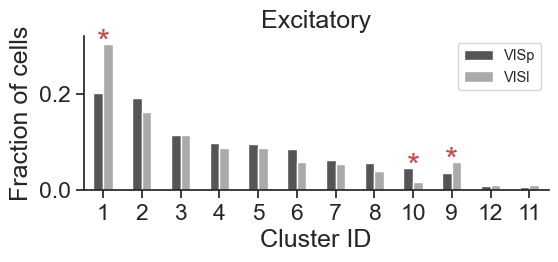

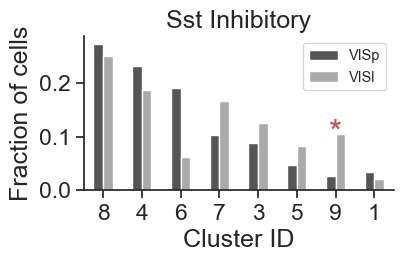

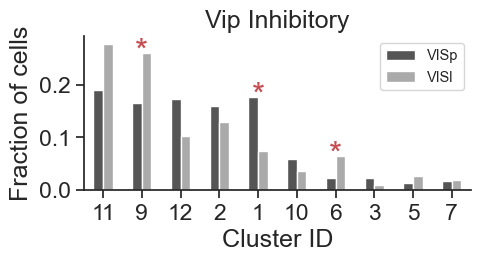

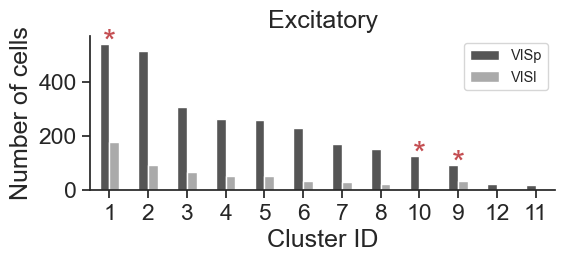

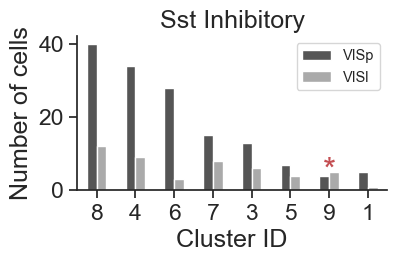

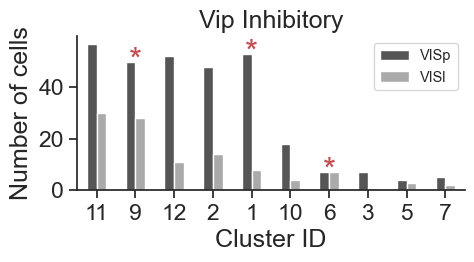

In [276]:
location = 'targeted_structure'

metric = 'fraction_cells_location'
ylabel = 'Fraction of cells'
plotting.plot_cluster_depth_distribution_by_cre_line_separately(cluster_meta, location, metric, ylabel, save_dir=save_dir, folder='area_depth')


metric = 'n_cells_location'
ylabel = 'Number of cells'
plotting.plot_cluster_depth_distribution_by_cre_line_separately(cluster_meta, location, metric, ylabel, save_dir=save_dir, folder='area_depth')

## Coding and cell metrics for clusters

### Coding score metrics

In [70]:
# load pre-saved coding score metrics 
coding_score_metrics = processing.generate_coding_score_metrics_table(cluster_meta, results_pivoted, 
                                                                      save_dir=clustering_results)

loading coding score metrics table


#### Experience modulation by cluster id and cell class

<Axes: title={'center': 'Experience modulation'}, xlabel='cluster ID', ylabel='<- Familiar --- Novel ->'>

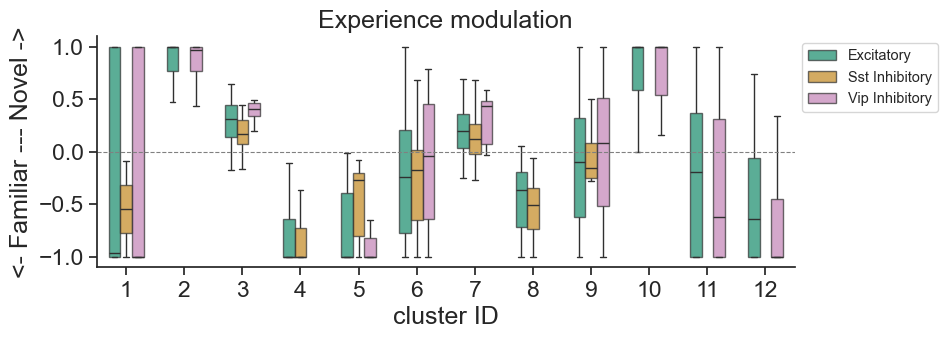

In [71]:
plotting.plot_experience_modulation(coding_score_metrics, metric='experience_modulation', save_dir=save_dir, 
                                    folder='metric_distributions')

#### Experience modulation vs cortical depth

In [72]:
cluster_metrics = processing.get_cluster_metrics(cluster_meta, feature_matrix, results_pivoted)

location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

cluster_metrics = processing.add_layer_index_to_cluster_metrics(cluster_metrics, n_cells_table)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


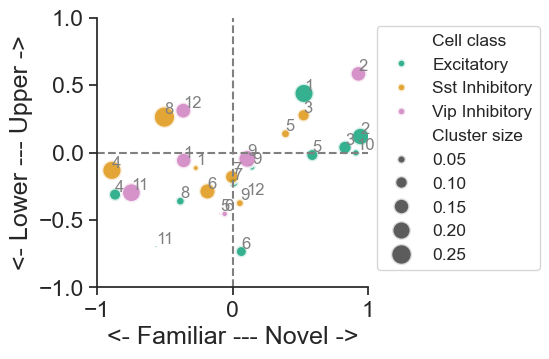

In [73]:

x = 'exp_mod_direction' # novel-familiar / sum
y = 'layer_index' # upper-lower / sum
hue = 'cell_type'

if 'cell_type' not in cluster_metrics.columns:
    cluster_metrics['cell_type'] = [utils.convert_cre_line_to_cell_type(cre_line) for cre_line in cluster_metrics.index.get_level_values(0)]

plotting.plot_cluster_metric_comparison_scatterplot(cluster_metrics, cluster_meta, x=x, y=y, hue=hue, save_dir=save_dir, folder='metrics_distributions')

### Cell metrics for clusters

In [74]:
# save_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4\all_cre_clustering_113023'
metrics = processing.generate_merged_table_of_coding_score_and_model_free_metrics(cluster_meta, results_pivoted,
                                                                 data_type='events',
                                                                 session_subset='full_session',
                                                                 inclusion_criteria='platform_experiment_table',
                                                                 save_dir=clustering_results)

loading coding score and model free metrics table


In [75]:
print(len(metrics.ophys_experiment_id.unique()))
print(len(metrics.cell_specimen_id.unique()))

393
3901


In [76]:
response_metrics = metrics.copy()

#### Image selectivity

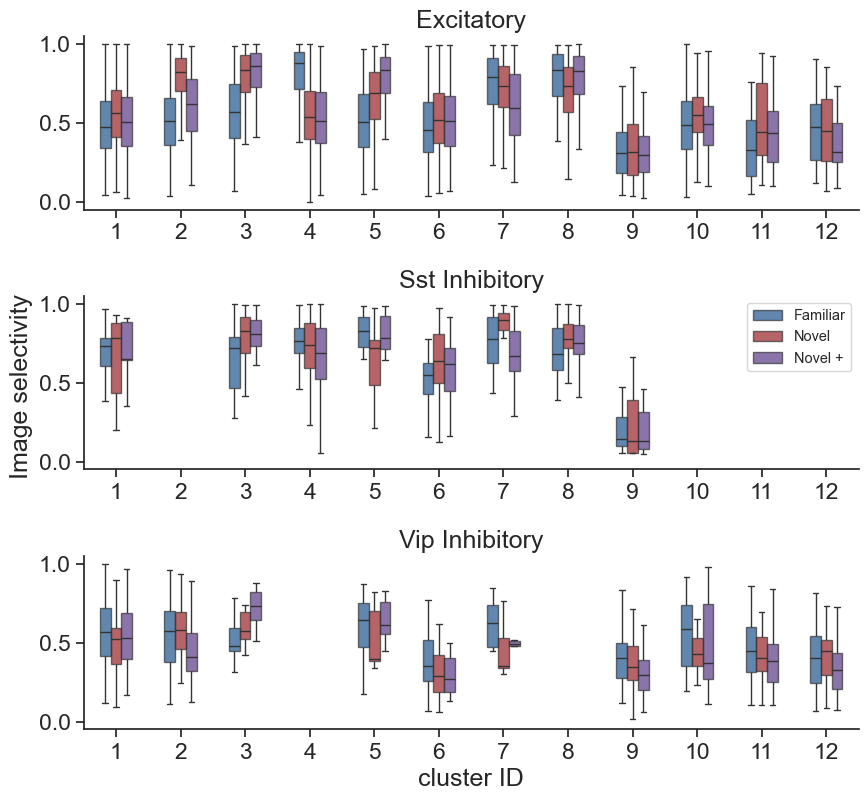

In [77]:
metric = 'lifetime_sparseness_images'
ylabel = 'Image selectivity '

plotting.plot_response_metrics_boxplot_by_cre(response_metrics, metric, ylabel=ylabel,
                                              save_dir=save_dir, folder='metrics_distributions')

#### Mean response - images

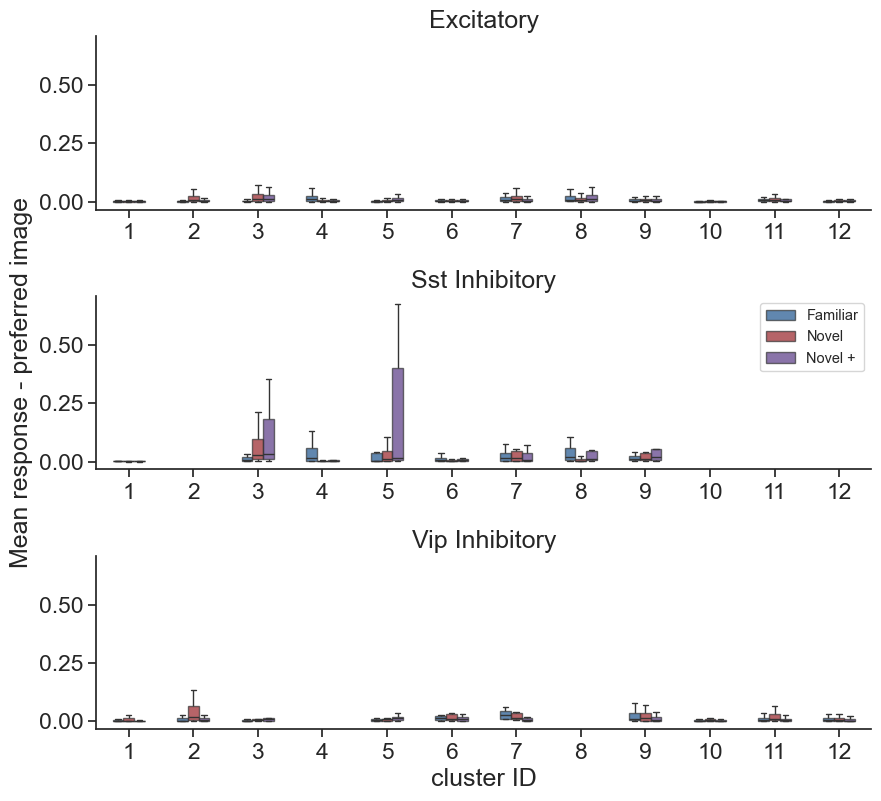

In [78]:
metric = 'mean_response_pref_image'
ylabel = 'Mean response - preferred image'

plotting.plot_response_metrics_boxplot_by_cre(response_metrics, metric, ylabel=ylabel,
                                              save_dir=save_dir, folder='metrics_distributions')

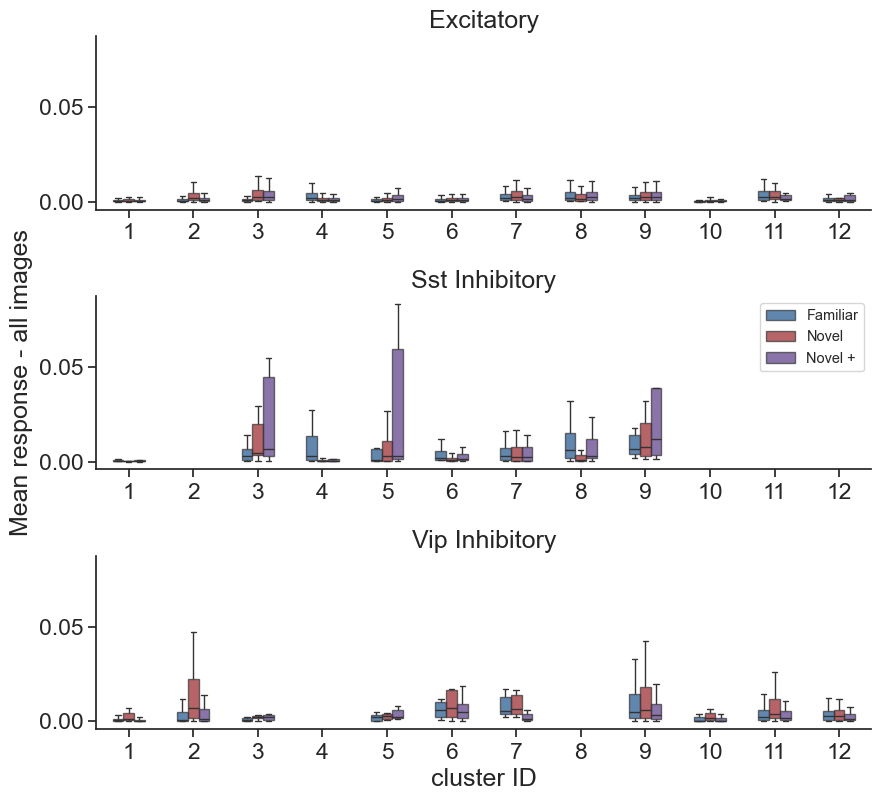

In [79]:
metric = 'mean_response_all_images'
ylabel = 'Mean response - all images'

plotting.plot_response_metrics_boxplot_by_cre(response_metrics, metric, ylabel=ylabel,
                                              save_dir=save_dir, folder='metrics_distributions')

#### Reliability - pref image

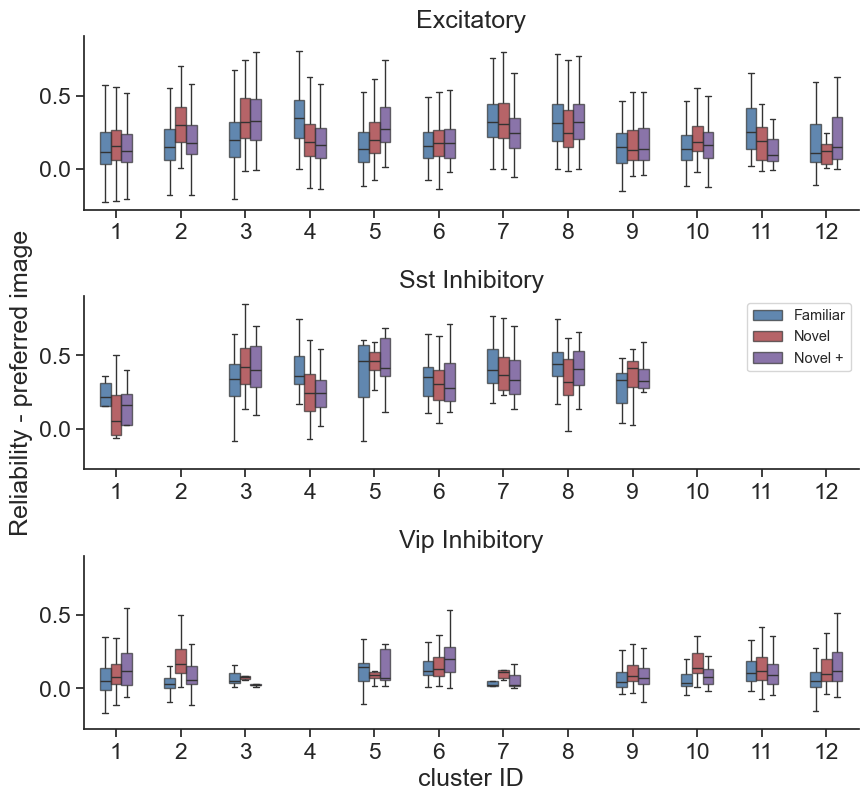

In [80]:
metric = 'reliability_pref_image'
ylabel = 'Reliability - preferred image'

plotting.plot_response_metrics_boxplot_by_cre(response_metrics, metric, ylabel=ylabel,
                                              save_dir=save_dir, folder='metrics_distributions')

#### Fano factor - pref image

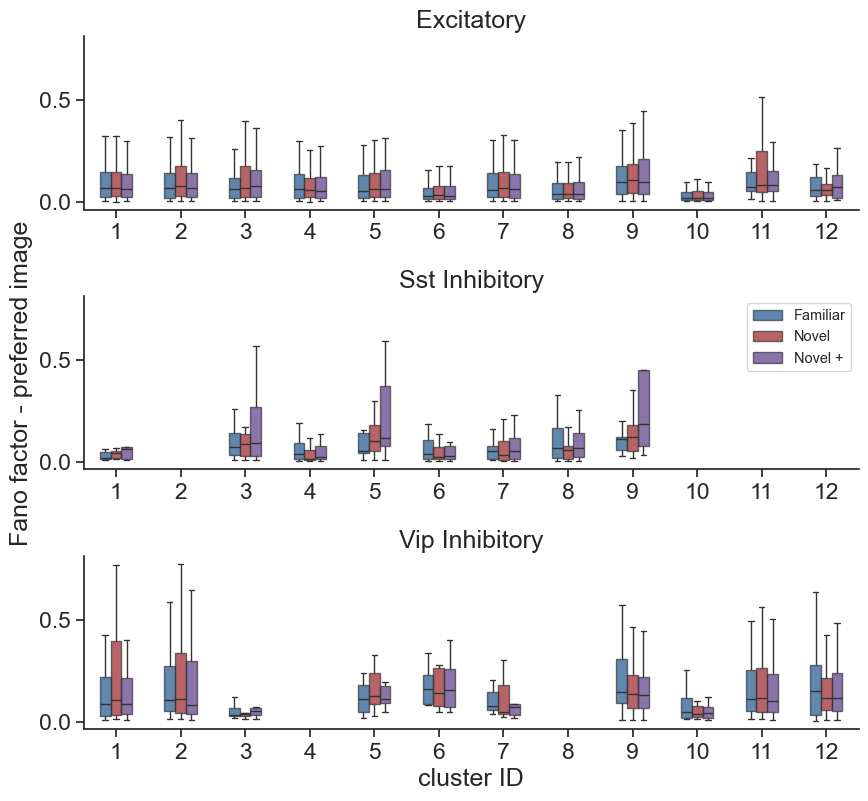

In [81]:
metric = 'fano_factor_pref_image'
ylabel = 'Fano factor - preferred image'

plotting.plot_response_metrics_boxplot_by_cre(response_metrics, metric, ylabel=ylabel,
                                              save_dir=save_dir, folder='metrics_distributions')

#### Reliability - changes

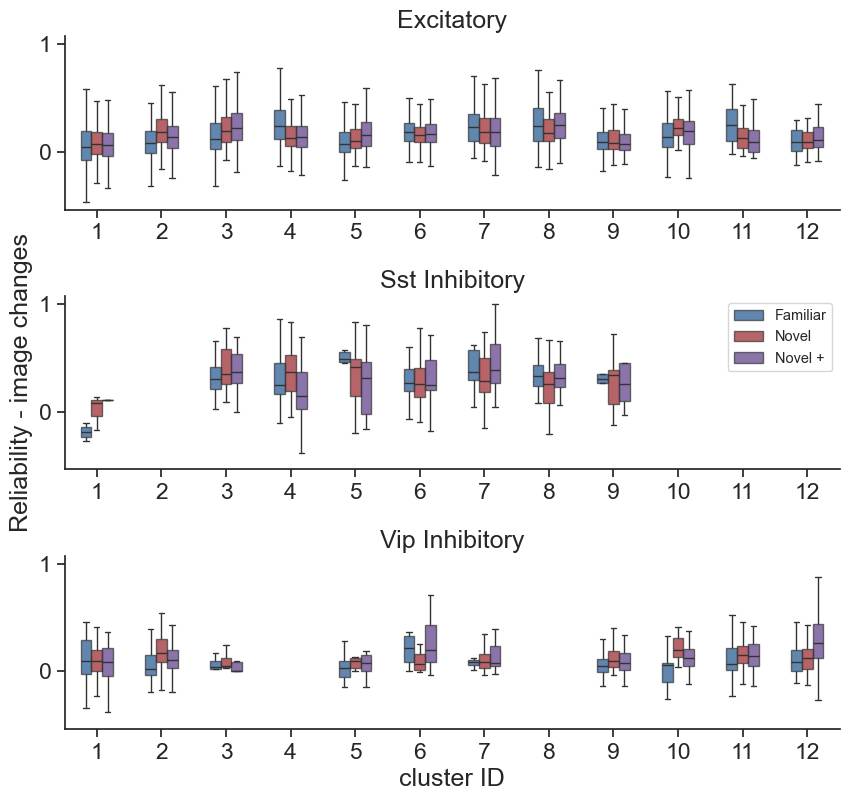

In [82]:
metric = 'reliability_changes'
ylabel = 'Reliability - image changes'

plotting.plot_response_metrics_boxplot_by_cre(response_metrics, metric, ylabel=ylabel,
                                              save_dir=save_dir, folder='metrics_distributions')

#### Mean response - changes

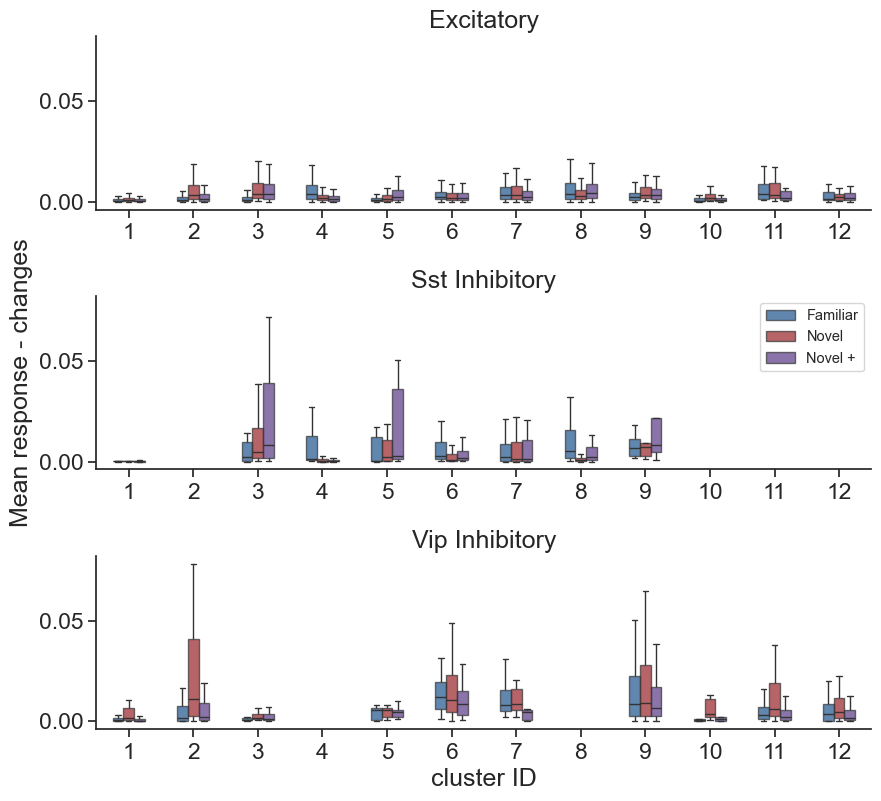

In [83]:
metric = 'mean_response_changes'
ylabel = 'Mean response - changes'

plotting.plot_response_metrics_boxplot_by_cre(response_metrics, metric, ylabel=ylabel,
                                              save_dir=save_dir, folder='metrics_distributions')

#### Change modulation

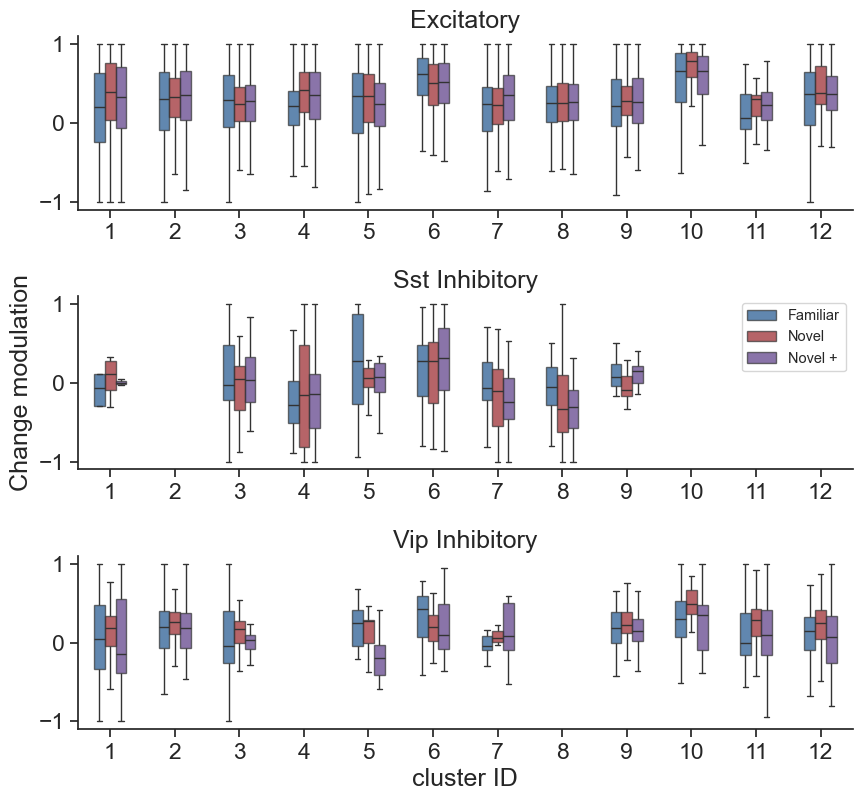

In [84]:
metric = 'change_modulation_index'
ylabel = 'Change modulation'

plotting.plot_response_metrics_boxplot_by_cre(response_metrics, metric, ylabel=ylabel,
                                              save_dir=save_dir, folder='metrics_distributions')

#### Choice modulation 

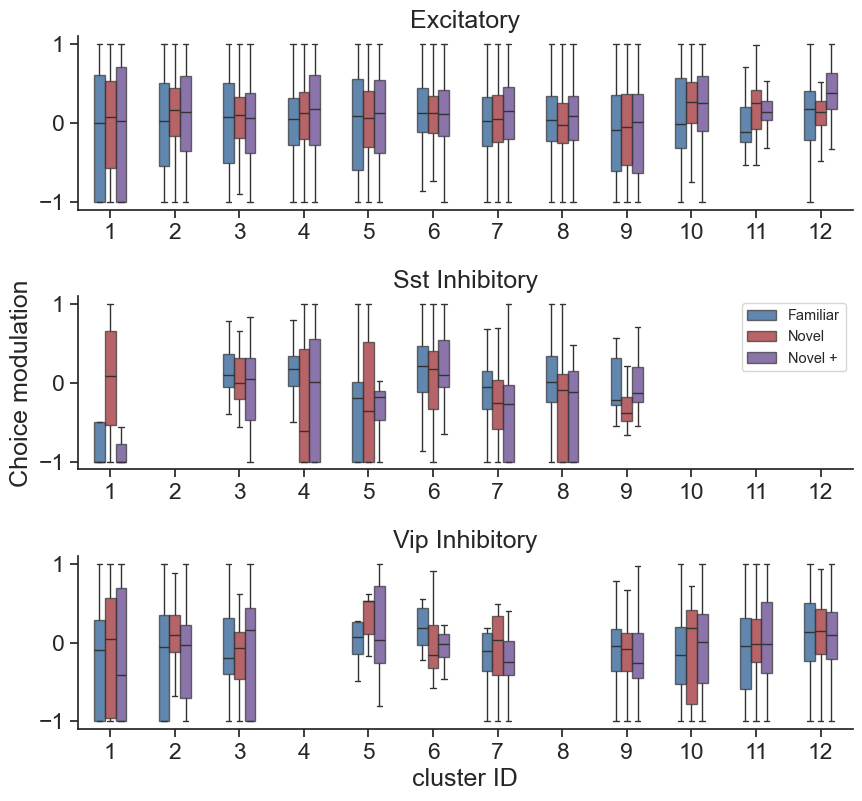

In [85]:
metric = 'hit_miss_index'
ylabel = 'Choice modulation'

plotting.plot_response_metrics_boxplot_by_cre(response_metrics, metric, ylabel=ylabel,
                                              save_dir=save_dir, folder='metrics_distributions')

#### Omission modulation 

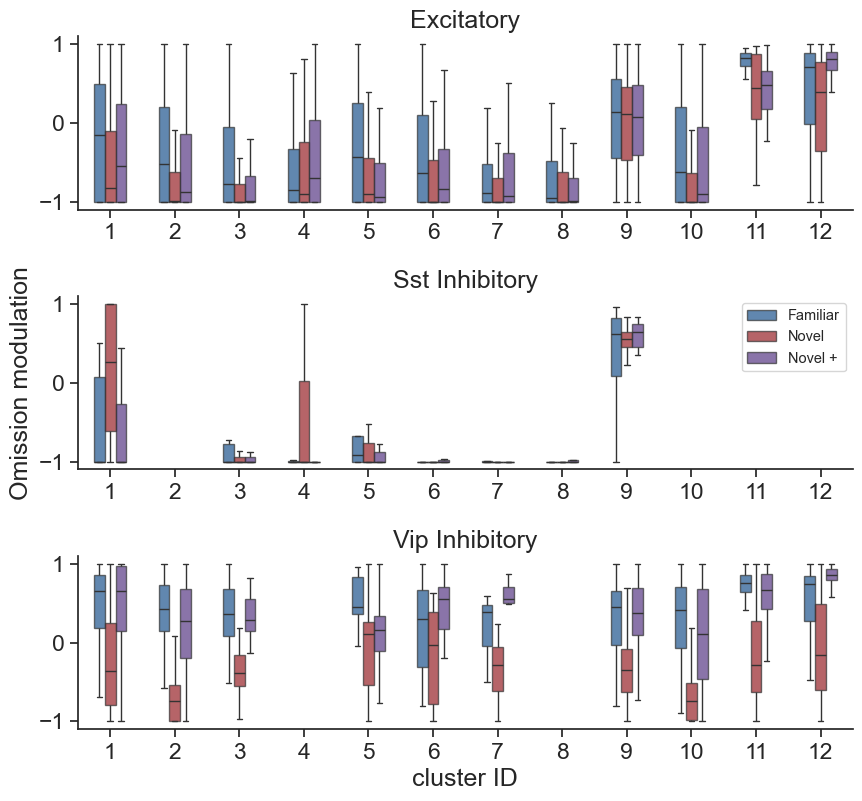

In [86]:
metric = 'omission_modulation_index'
ylabel = 'Omission modulation'

plotting.plot_response_metrics_boxplot_by_cre(response_metrics, metric, ylabel=ylabel,
                                              save_dir=save_dir, folder='metrics_distributions')

#### Mean response - omissions

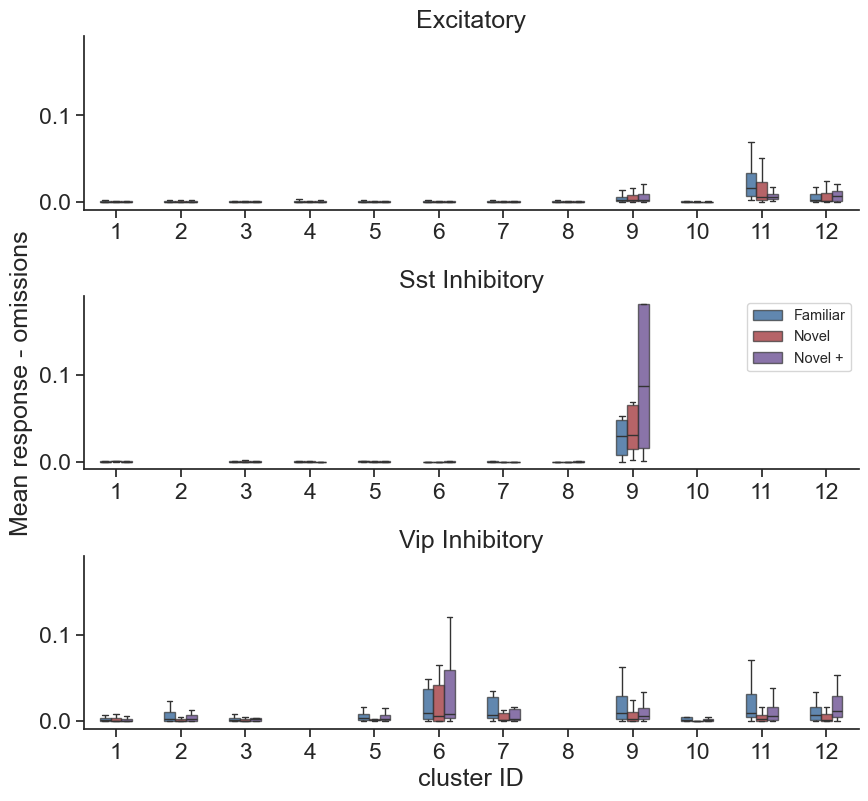

In [87]:
metric = 'mean_response_omissions'
ylabel = 'Mean response - omissions'

plotting.plot_response_metrics_boxplot_by_cre(response_metrics, metric, ylabel=ylabel,
                                              save_dir=save_dir, folder='metrics_distributions')

#### Reliability - omissions

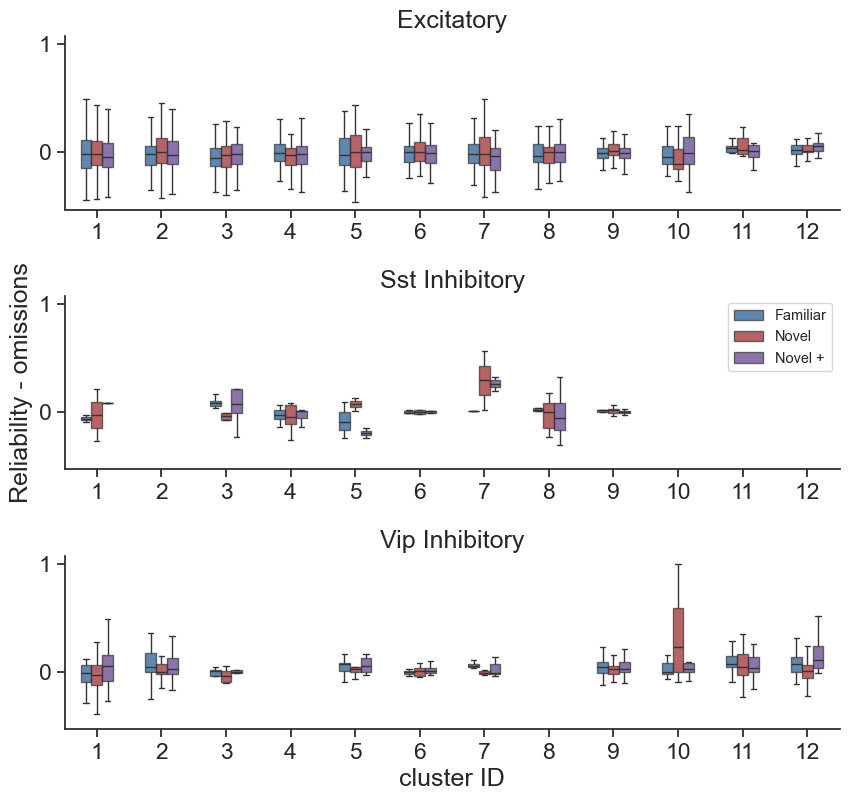

In [88]:
metric = 'reliability_omissions'
ylabel = 'Reliability - omissions'

plotting.plot_response_metrics_boxplot_by_cre(response_metrics, metric, ylabel=ylabel,
                                              save_dir=save_dir, folder='metrics_distributions')

#### Fano factor - omissions

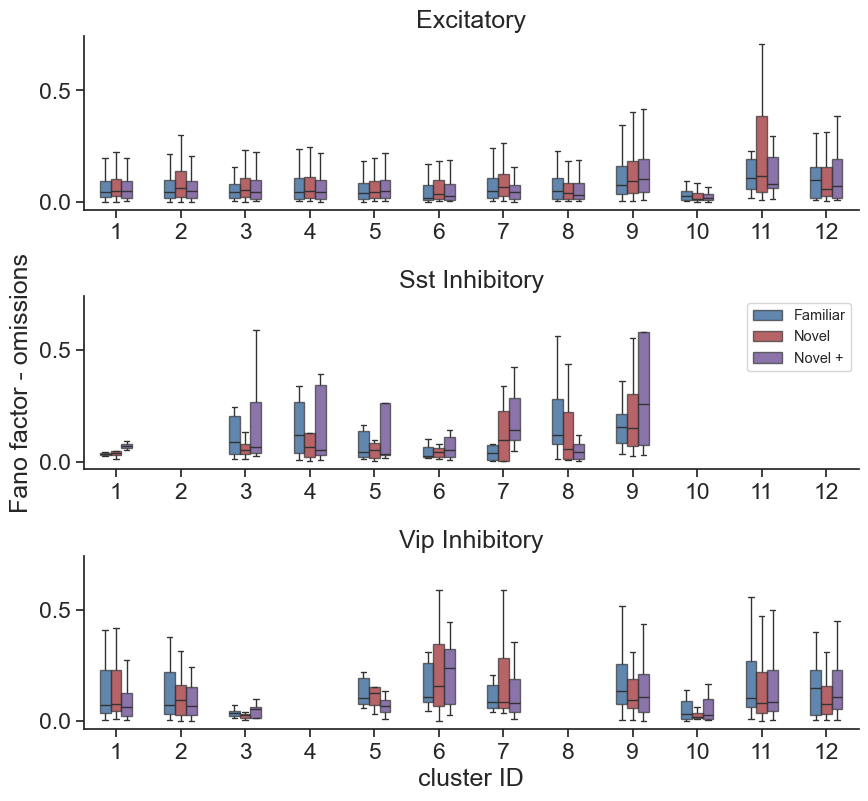

In [89]:
metric = 'fano_factor_omissions'
ylabel = 'Fano factor - omissions'

plotting.plot_response_metrics_boxplot_by_cre(response_metrics, metric, ylabel=ylabel,
                                              save_dir=save_dir, folder='metrics_distributions')

#### Running modulation 

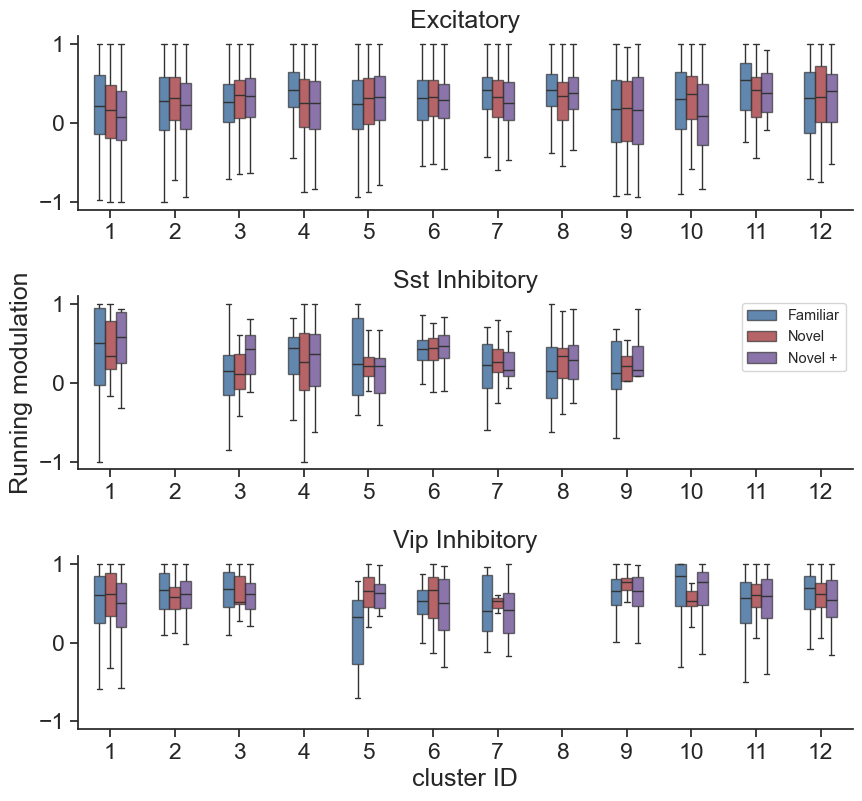

In [90]:
metric = 'running_modulation_all_images'
ylabel = 'Running modulation'

plotting.plot_response_metrics_boxplot_by_cre(response_metrics, metric, ylabel=ylabel,
                                              save_dir=save_dir, folder='metrics_distributions')

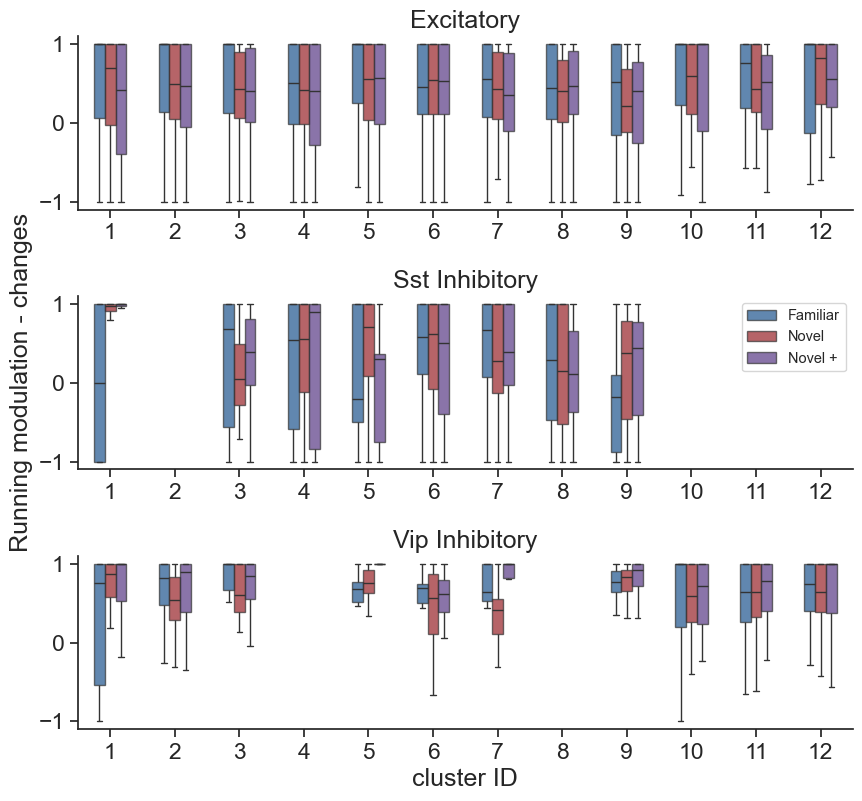

In [91]:
metric = 'running_modulation_changes'
ylabel = 'Running modulation - changes'

plotting.plot_response_metrics_boxplot_by_cre(response_metrics, metric, ylabel=ylabel,
                                              save_dir=save_dir, folder='metrics_distributions')

## stats

In [92]:
from scipy.stats import f_oneway

# Group data by 'cluster_id' and collect 'running_modulation' values for each group
response_metrics_clean = response_metrics.dropna(subset=['running_modulation_all_images'])

groups = [data for _, data in response_metrics_clean.groupby('cluster_id')['running_modulation_all_images']]

# Perform one-way ANOVA test
f_statistic, p_value = f_oneway(*groups)

print("F-statistic:", f_statistic)
print("p-value:", p_value)

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the means of the groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means of the groups.")

F-statistic: 27.5757061175136
p-value: 1.0747802808048578e-57
Reject the null hypothesis: There is a significant difference between the means of the groups.


In [93]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

# Create a MultiComparison object
multi_comp = MultiComparison(response_metrics_clean['running_modulation_all_images'], response_metrics_clean['cluster_id'])

# Perform Tukey's HSD test
tukey_results = multi_comp.tukeyhsd()

# Print the summary of the test
print(tukey_results.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0974  0.001  0.0556 0.1392   True
     1      3   0.1104  0.001  0.0617 0.1592   True
     1      4    0.097  0.001  0.0461 0.1478   True
     1      5   0.0835  0.001  0.0312 0.1358   True
     1      6   0.1299  0.001  0.0766 0.1832   True
     1      7   0.1237  0.001  0.0644  0.183   True
     1      8   0.1414  0.001  0.0817 0.2012   True
     1      9   0.1417  0.001  0.0805  0.203   True
     1     10   0.1087  0.001  0.0393 0.1781   True
     1     11   0.3073  0.001  0.2269 0.3877   True
     1     12    0.308  0.001  0.2202 0.3957   True
     2      3    0.013    0.9 -0.0371 0.0631  False
     2      4  -0.0004    0.9 -0.0526 0.0517  False
     2      5  -0.0139    0.9 -0.0676 0.0397  False
     2      6   0.0325 0.7015 -0.0221 0.0871  False
     2      7   0.0263    0.9 -0.0341 0.0867  False
     2      

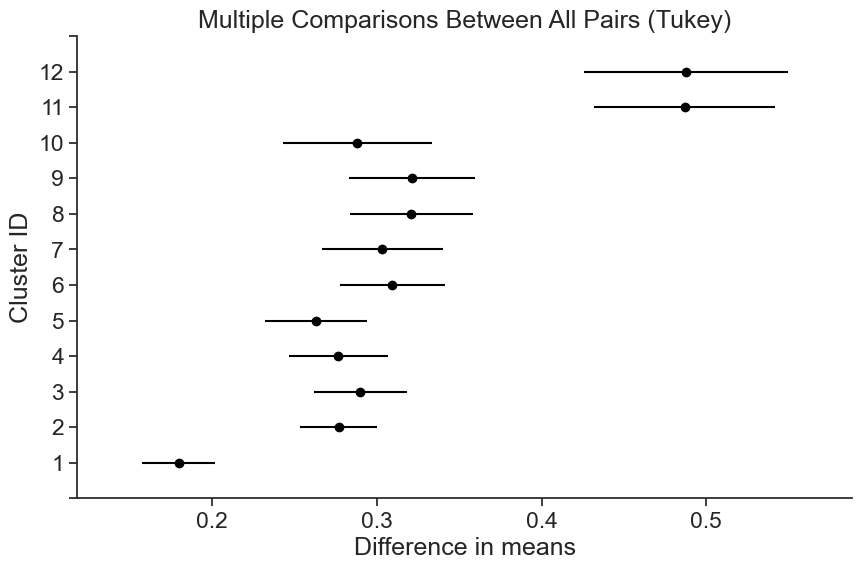

In [94]:


# Plot the results in a grid
tukey_results.plot_simultaneous(ylabel='Cluster ID', xlabel='Difference in means')

plt.show()